In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from py_funcs.func_units import *
from py_funcs.func_project_dir import *
warnings.simplefilter('ignore')

sns.set_style("darkgrid")
dark_palette = sns.color_palette("colorblind")
sns.set_palette(dark_palette)
sns.set_color_codes("colorblind")

In [2]:
map_units = get_units()
map_units = {str(k).upper(): v for k, v in map_units.items()}
map_units["URINE"] = "mL"

In [3]:
###########################################################################
### Function for removing outliers by IQR
###########################################################################
def remove_outliers_iqr(group, skip_group_name=None):
    # Prüfen, ob die Gruppe basierend auf einem Namensteil übersprungen werden soll
    if skip_group_name is not None and any(name_part in group.name for name_part in skip_group_name):
        return group
    else:
        Q1  = group['VALUENUM'].quantile(0.25)
        Q3  = group['VALUENUM'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR 
        upper_bound = Q3 + 1.5 * IQR 
        return group[(group['VALUENUM'] >= lower_bound) & (group['VALUENUM'] <= upper_bound)]

In [4]:
df_subjects = pd.read_csv(project_path()+r"/data/extracted_data/subjects.csv", index_col=0)
df_filter   = df_subjects[df_subjects["AGE"] > 14][["SUBJECT_ID", "ICUSTAY_ID"]]

# Chartevents

## Read data

In [5]:
df_chartevents          = pd.read_csv(project_path()+r"/data/extracted_data/chartevents.csv", index_col=0).merge(df_filter[["ICUSTAY_ID"]])
df_chartevents["LABEL"] = df_chartevents["LABEL"].str.upper()

## Exploration With Outliers

### Hist Plot

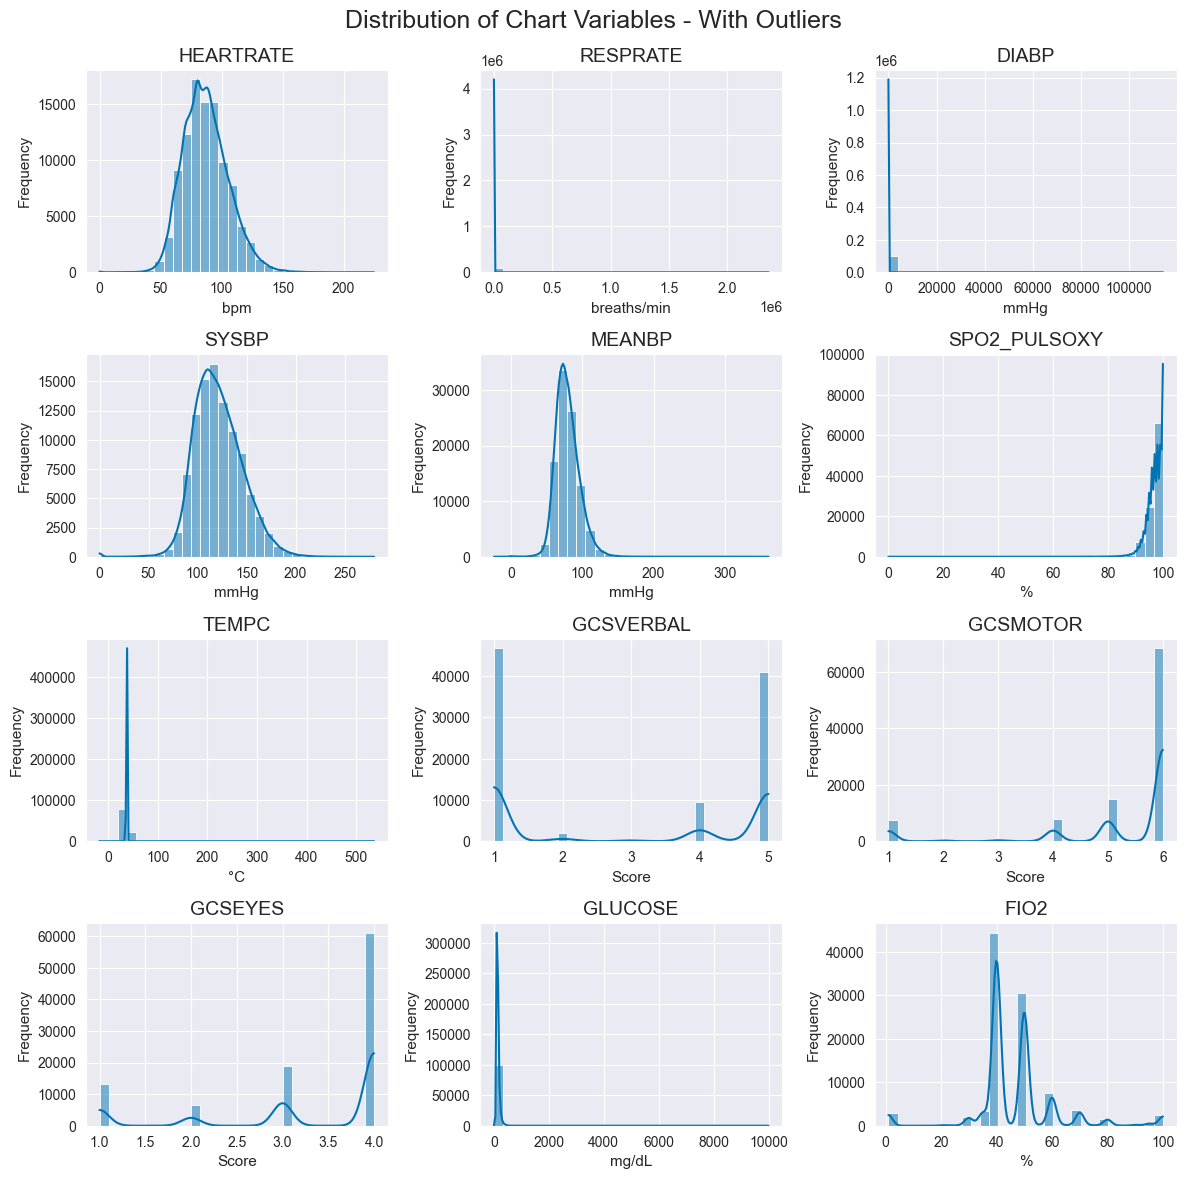

In [6]:
n_cols      = 3
n_labels    = len(df_chartevents["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Distribution of Chart Variables - With Outliers", fontsize=18)
for i, label in enumerate(df_chartevents["LABEL"].unique()):
    data = df_chartevents[df_chartevents["LABEL"] == label].sample(n=100000, random_state=42)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data, x="VALUENUM", kde=True, bins=30)
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.93) 
plt.show()

### CDF plot

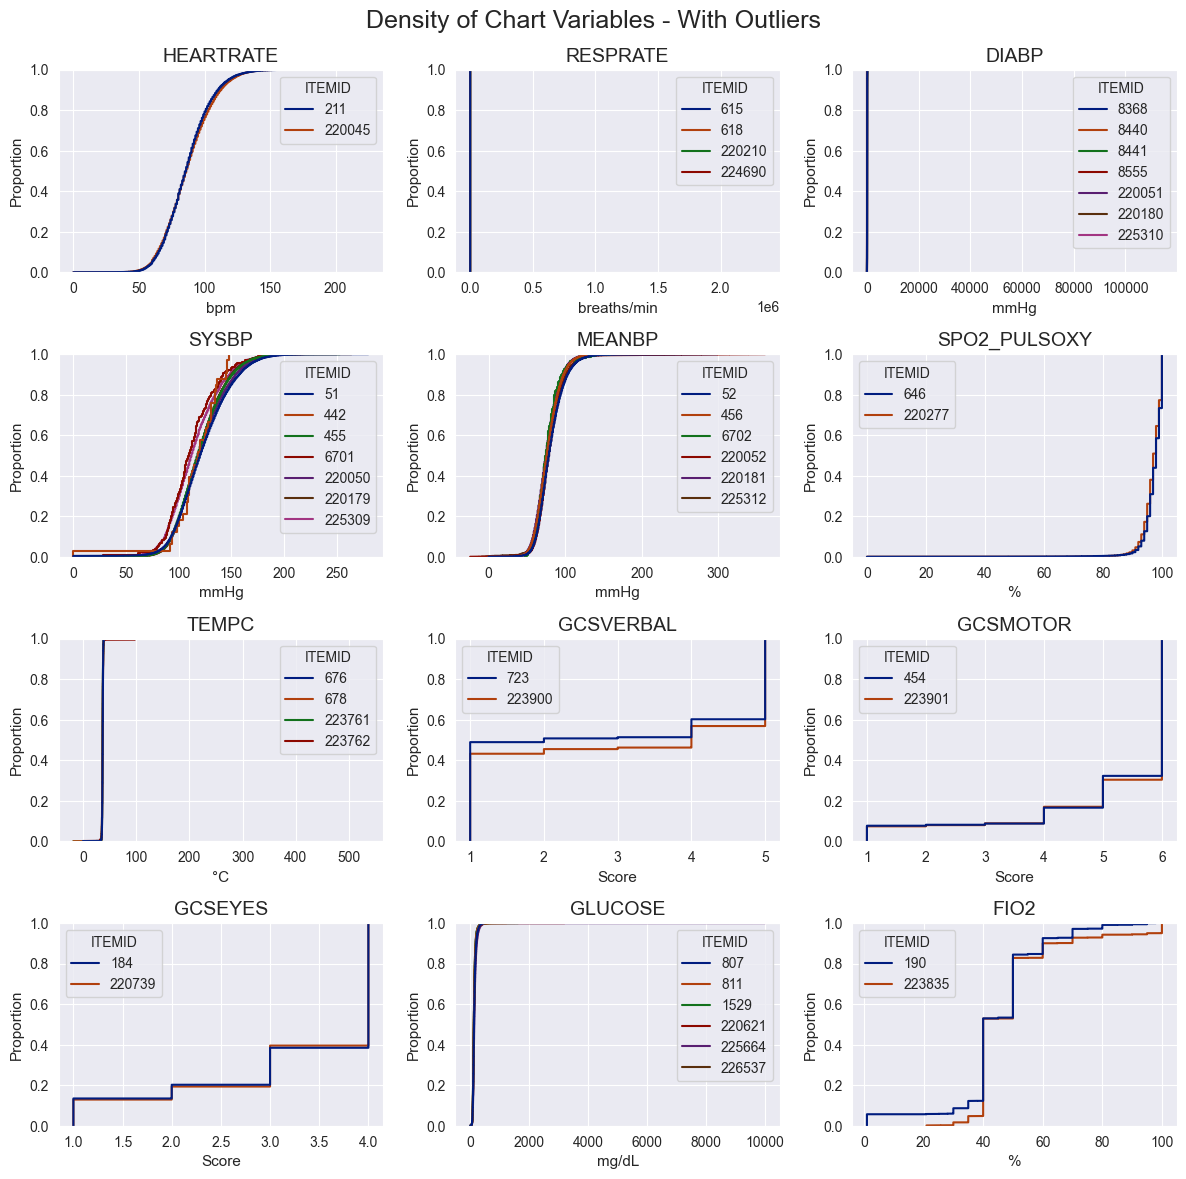

In [7]:
n_cols      = 3
n_labels    = len(df_chartevents["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Density of Chart Variables - With Outliers", fontsize=18)
for i, label in enumerate(df_chartevents["LABEL"].unique()):
    data = df_chartevents[df_chartevents["LABEL"] == label].sample(n=100000, random_state=42)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.ecdfplot(data, x="VALUENUM", hue="ITEMID", palette="dark")
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Proportion", fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.93) 
plt.show()

### Violin-Plots

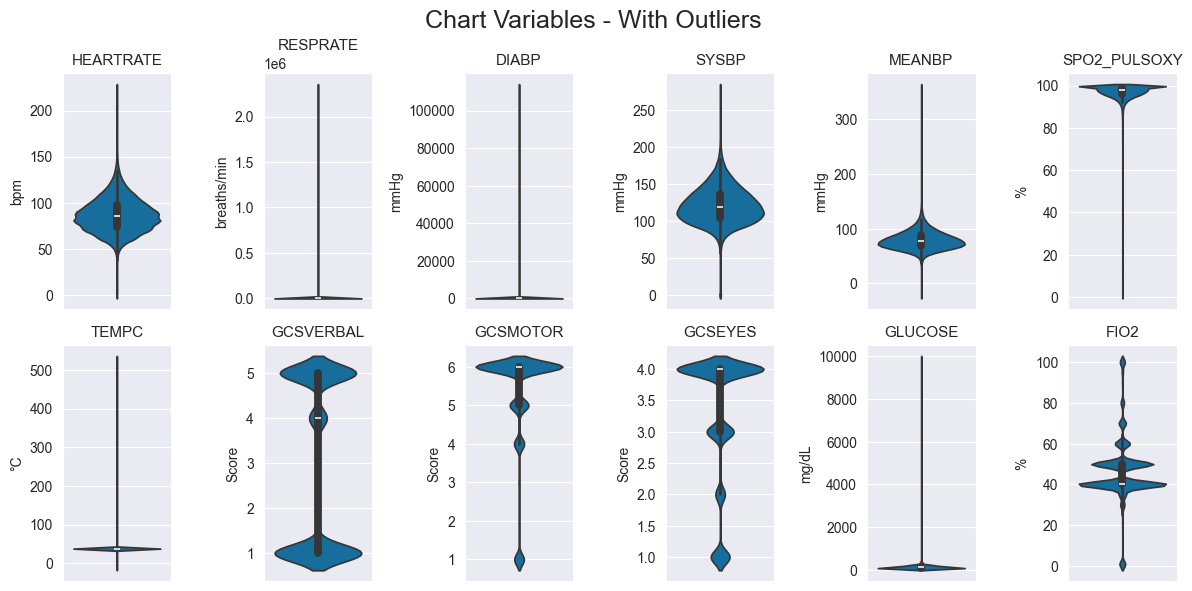

In [8]:
labels = df_chartevents['LABEL'].unique()
n_labels = len(labels)

n_cols = 6
n_rows = int(np.ceil(n_labels / n_cols))  

plt.figure(figsize=(2 * n_cols, 3 * n_rows))
plt.suptitle("Chart Variables - With Outliers", fontsize=18)
for i, label in enumerate(labels):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=df_chartevents[df_chartevents['LABEL'] == label].sample(n=100000, random_state=42), 
                   y="VALUENUM")
    plt.ylabel(map_units[label]) 
    plt.title(label, fontsize=11)

plt.tight_layout(pad=1.2)
# plt.subplots_adjust(top=0.95)
plt.show()

### Descriptive statistics

In [9]:
desc_chart = df_chartevents.groupby("LABEL")[df_chartevents.columns[3:]].describe().round(2).sort_values(by=("VALUENUM", "count"), ascending=False).round(0)
desc_chart[('VALUENUM', 'count')] = desc_chart[('VALUENUM', 'count')].astype(int)
desc_chart

VALUENUM                                                      
                count   mean     std    min    25%    50%    75%        max
LABEL                                                                      
RESPRATE      6930702   20.0   895.0   -1.0   16.0   20.0   24.0  2355555.0
HEARTRATE     6242142   89.0  4003.0  -88.0   74.0   86.0   98.0  9999999.0
SYSBP         6205905  121.0   127.0  -69.0  104.0  119.0  136.0   141146.0
DIABP         6202563   61.0   235.0  -16.0   50.0   59.0   69.0   114109.0
MEANBP        6164380   79.0   101.0 -135.0   68.0   77.0   88.0   120130.0
SPO2_PULSOXY  6083272   99.0  2940.0    0.0   96.0   98.0   99.0  6363333.0
TEMPC         1738952   37.0     5.0  -73.0   36.0   37.0   38.0     5336.0
GLUCOSE       1561742  141.0  1146.0 -124.0  106.0  128.0  158.0   999999.0
GCSEYES       1519998    3.0     1.0    1.0    3.0    4.0    4.0        4.0
GCSVERBAL     1515751    3.0     2.0    1.0    1.0    4.0    5.0        5.0
GCSMOTOR      1513613    5.0     1.0    1.0    5.0    6.0    6.0        6.0
FIO2          1124396   47.0    15.0    1.0   40.0   40.0   50.0      100.0

## Percentage of outliers

In [10]:
df_chartevents_or                 = df_chartevents.groupby("LABEL").apply(lambda group: remove_outliers_iqr(group, skip_group_name=['GCS', 'FIO2'])).reset_index(drop=True)
chartevents_outliers_percentage   = (1 - (df_chartevents_or.groupby("LABEL")["VALUENUM"].count() / df_chartevents.groupby("LABEL")["VALUENUM"].count()))
print("chart data percentage of outliers")
print(chartevents_outliers_percentage.sort_values().apply(lambda x: str(round(x *100,2)) + "%"))

chart data percentage of outliers
LABEL
FIO2             0.0%
GCSEYES          0.0%
GCSMOTOR         0.0%
GCSVERBAL        0.0%
HEARTRATE       1.19%
SYSBP           1.38%
TEMPC           1.51%
DIABP           1.83%
RESPRATE         1.9%
MEANBP          2.33%
SPO2_PULSOXY     4.0%
GLUCOSE         5.21%
Name: VALUENUM, dtype: object


In [11]:
t = pd.DataFrame(chartevents_outliers_percentage)
t = t.sort_values(by="VALUENUM")
t["VALUENUM"] = t["VALUENUM"].apply(lambda x: str(round(x *100,2)) + "%")
t

VALUENUM
LABEL                
FIO2             0.0%
GCSEYES          0.0%
GCSMOTOR         0.0%
GCSVERBAL        0.0%
HEARTRATE       1.19%
SYSBP           1.38%
TEMPC           1.51%
DIABP           1.83%
RESPRATE         1.9%
MEANBP          2.33%
SPO2_PULSOXY     4.0%
GLUCOSE         5.21%

## Exploration Without Outliers

### Hist Plot

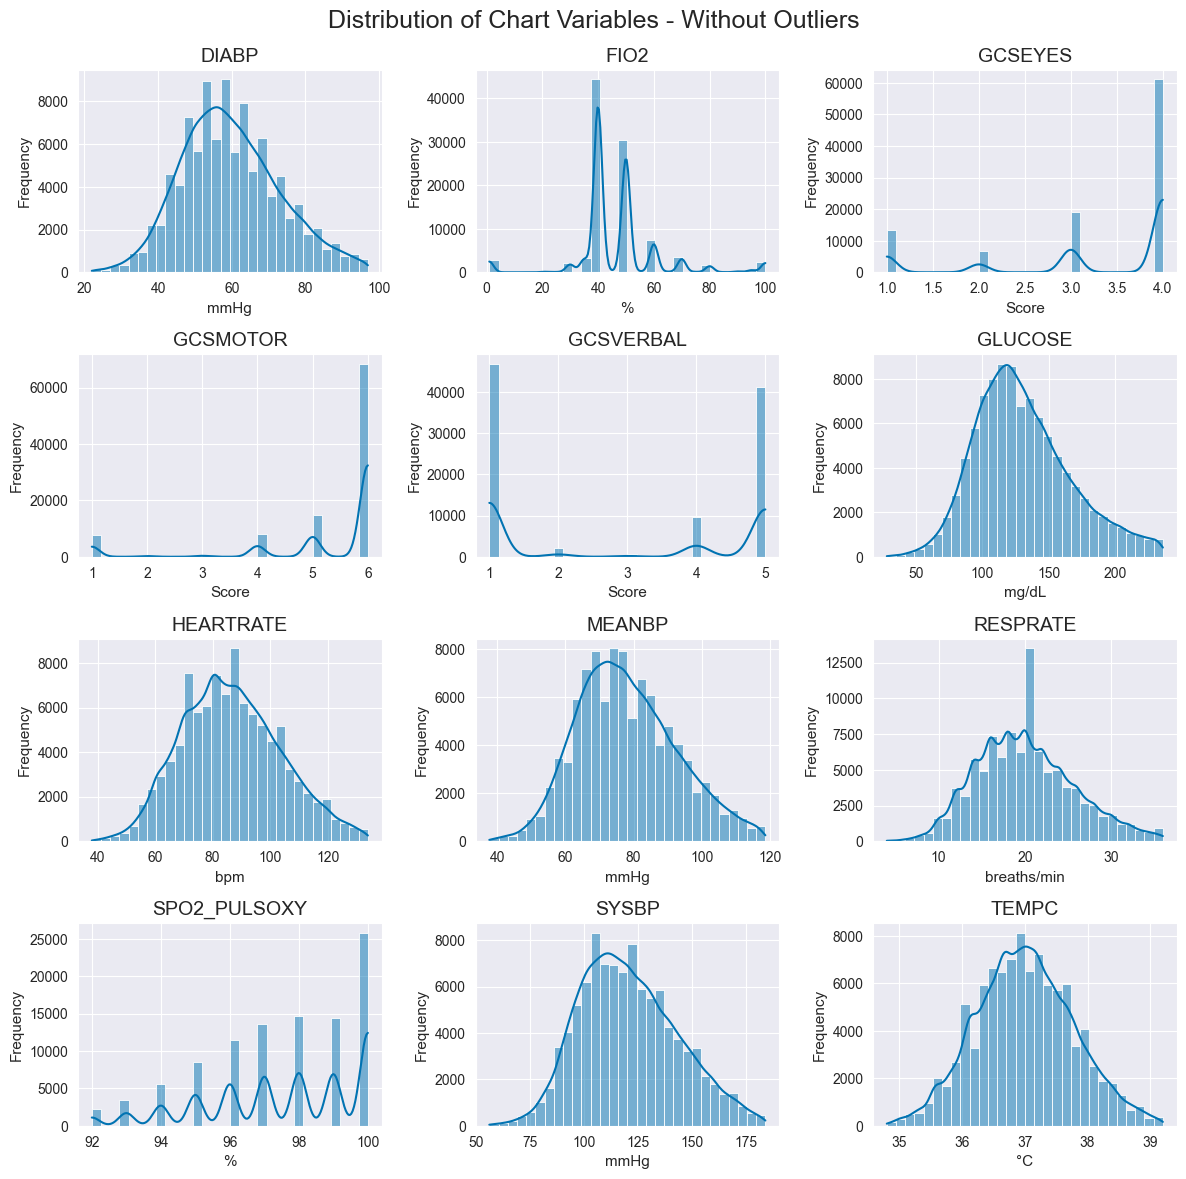

In [12]:
n_cols      = 3
n_labels    = len(df_chartevents_or["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Distribution of Chart Variables - Without Outliers", fontsize=18)
for i, label in enumerate(df_chartevents_or["LABEL"].unique()):
    data = df_chartevents_or[df_chartevents_or["LABEL"] == label].sample(n=100000, random_state=42)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data, x="VALUENUM", kde=True, bins=30)
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.93) 
plt.show()

### CDF plot

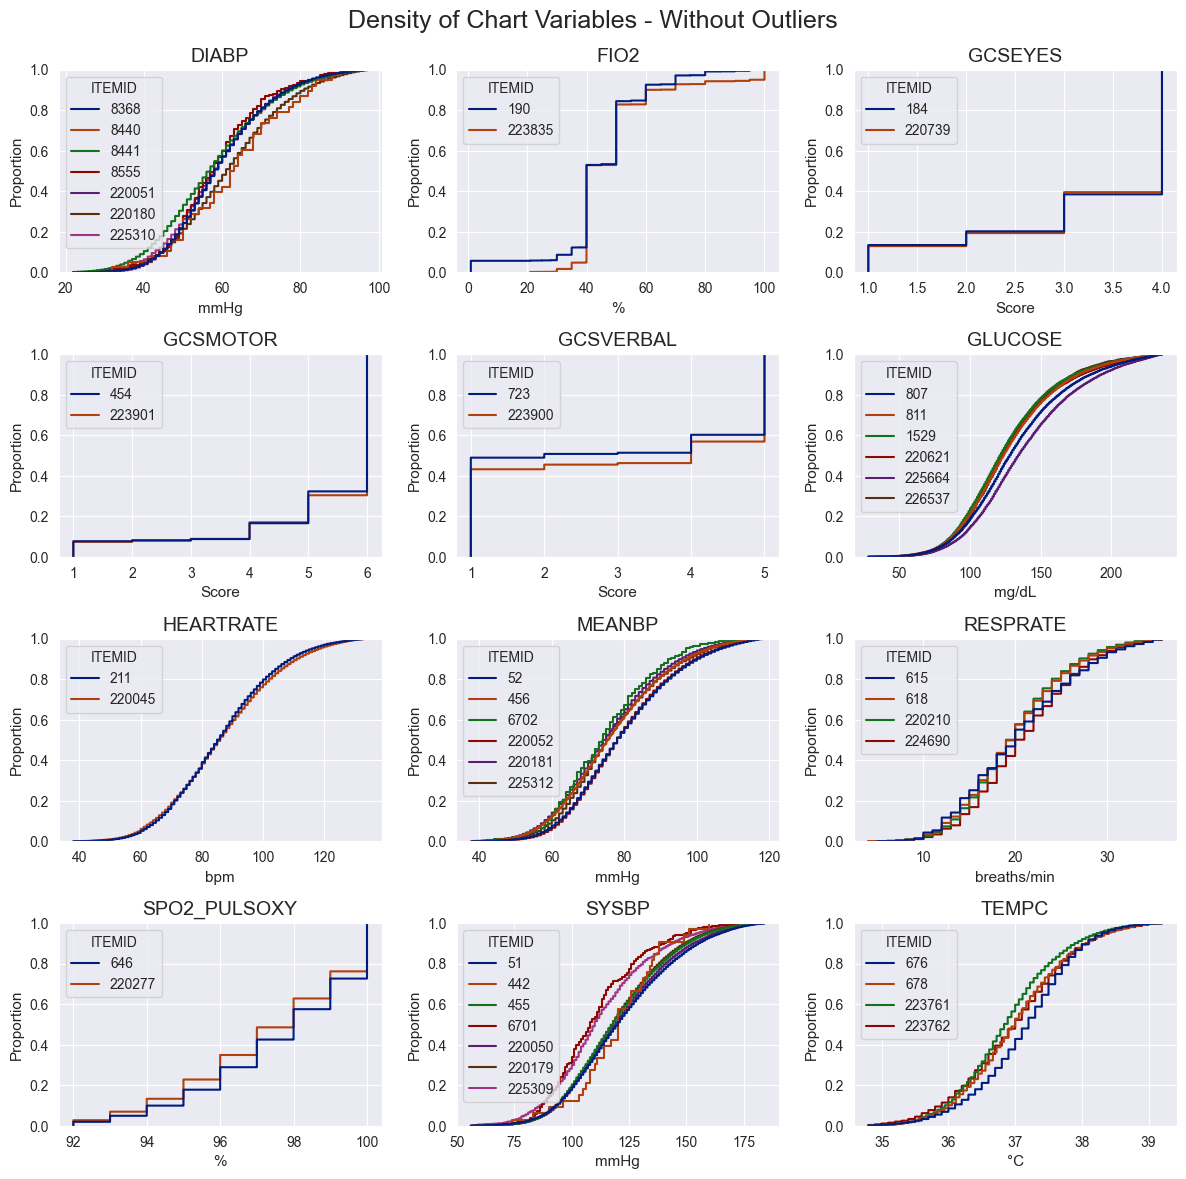

In [13]:
n_cols      = 3
n_labels    = len(df_chartevents_or["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Density of Chart Variables - Without Outliers", fontsize=18)
for i, label in enumerate(df_chartevents_or["LABEL"].unique()):
    data = df_chartevents_or[df_chartevents_or["LABEL"] == label].sample(n=100000, random_state=42)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.ecdfplot(data, x="VALUENUM", hue="ITEMID", palette="dark")
    plt.title(label, fontsize=14)    
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Proportion", fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.93) 
plt.show()

### Violin Plot

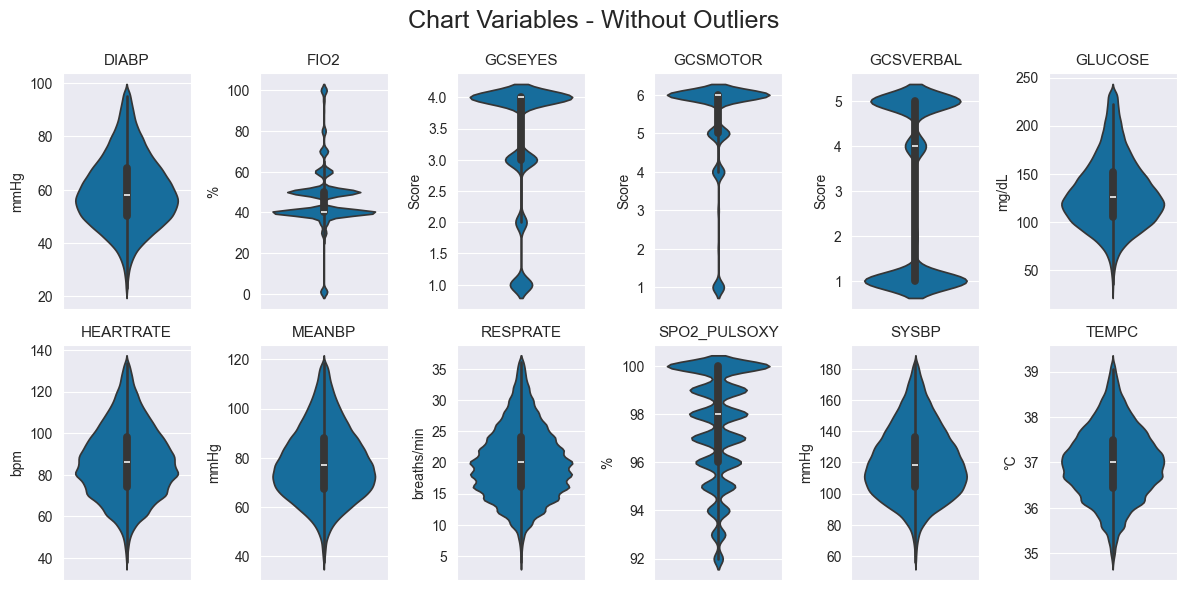

In [14]:
labels = df_chartevents_or['LABEL'].unique()
n_labels = len(labels)

n_cols = 6
n_rows = int(np.ceil(n_labels / n_cols))  

plt.figure(figsize=(2 * n_cols, 3 * n_rows))
plt.suptitle("Chart Variables - Without Outliers", fontsize=18)
for i, label in enumerate(labels):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=df_chartevents_or[df_chartevents_or['LABEL'] == label].sample(n=100000, random_state=42), 
                   y="VALUENUM")
    plt.ylabel(map_units[label]) 
    plt.title(label, fontsize=11)

plt.tight_layout(pad=1.2)
# plt.subplots_adjust(top=0.95)
plt.show()

### Descriptive statistics

In [15]:
desc_chart = df_chartevents_or.groupby("LABEL")[df_chartevents_or.columns[3:]].describe().round(2).sort_values(by=("VALUENUM", "count"), ascending=False).round(0)
desc_chart[('VALUENUM', 'count')] = desc_chart[('VALUENUM', 'count')].astype(int)
desc_chart

VALUENUM                                               
                count   mean   std   min    25%    50%    75%    max
LABEL                                                               
RESPRATE      6798741   20.0   6.0   4.0   16.0   20.0   24.0   36.0
HEARTRATE     6167912   86.0  17.0  38.0   74.0   85.0   98.0  134.0
SYSBP         6120302  121.0  23.0  56.0  104.0  118.0  136.0  184.0
DIABP         6089135   60.0  13.0  22.0   50.0   58.0   68.0   97.0
MEANBP        6020724   78.0  15.0  38.0   67.0   77.0   88.0  119.0
SPO2_PULSOXY  5839966   98.0   2.0  92.0   96.0   98.0  100.0  102.0
TEMPC         1712652   37.0   1.0  35.0   36.0   37.0   38.0   39.0
GCSEYES       1519998    3.0   1.0   1.0    3.0    4.0    4.0    4.0
GCSVERBAL     1515751    3.0   2.0   1.0    1.0    4.0    5.0    5.0
GCSMOTOR      1513613    5.0   1.0   1.0    5.0    6.0    6.0    6.0
GLUCOSE       1480451  131.0  36.0  28.0  105.0  126.0  152.0  236.0
FIO2          1124396   47.0  15.0   1.0   40.0   40.0   50.0  100.0

# Labevents

## Read data

In [16]:
df_labevents = pd.read_csv(project_path()+r"./data/extracted_data/labevents.csv", index_col=0).merge(df_filter[["SUBJECT_ID"]])

## Exploration With Outliers

### Hist Plot

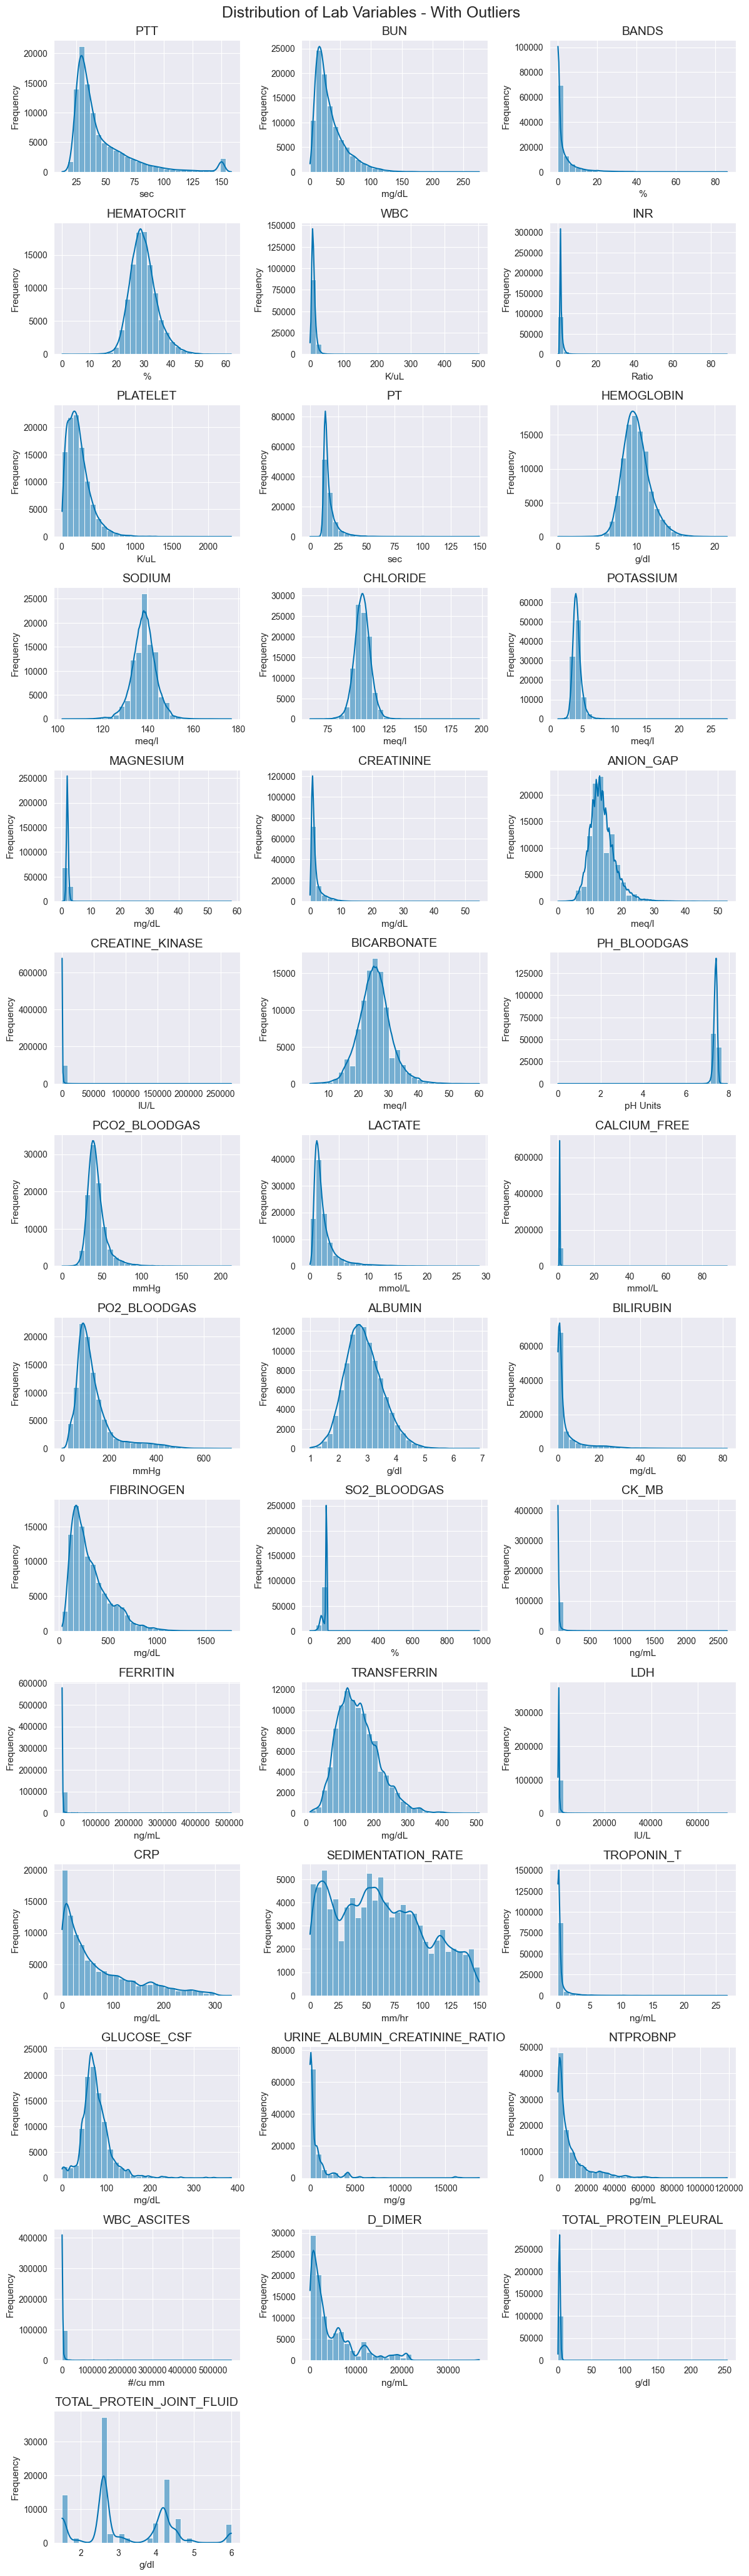

In [17]:
n_cols      = 3
n_labels    = len(df_labevents["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Distribution of Lab Variables - With Outliers", fontsize=18)
for i, label in enumerate(df_labevents["LABEL"].unique()):
    data = df_labevents[df_labevents["LABEL"] == label].sample(n=100000, random_state=42, replace=True)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data, x="VALUENUM", kde=True, bins=30)
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.967) 
plt.show()

### CDF plot

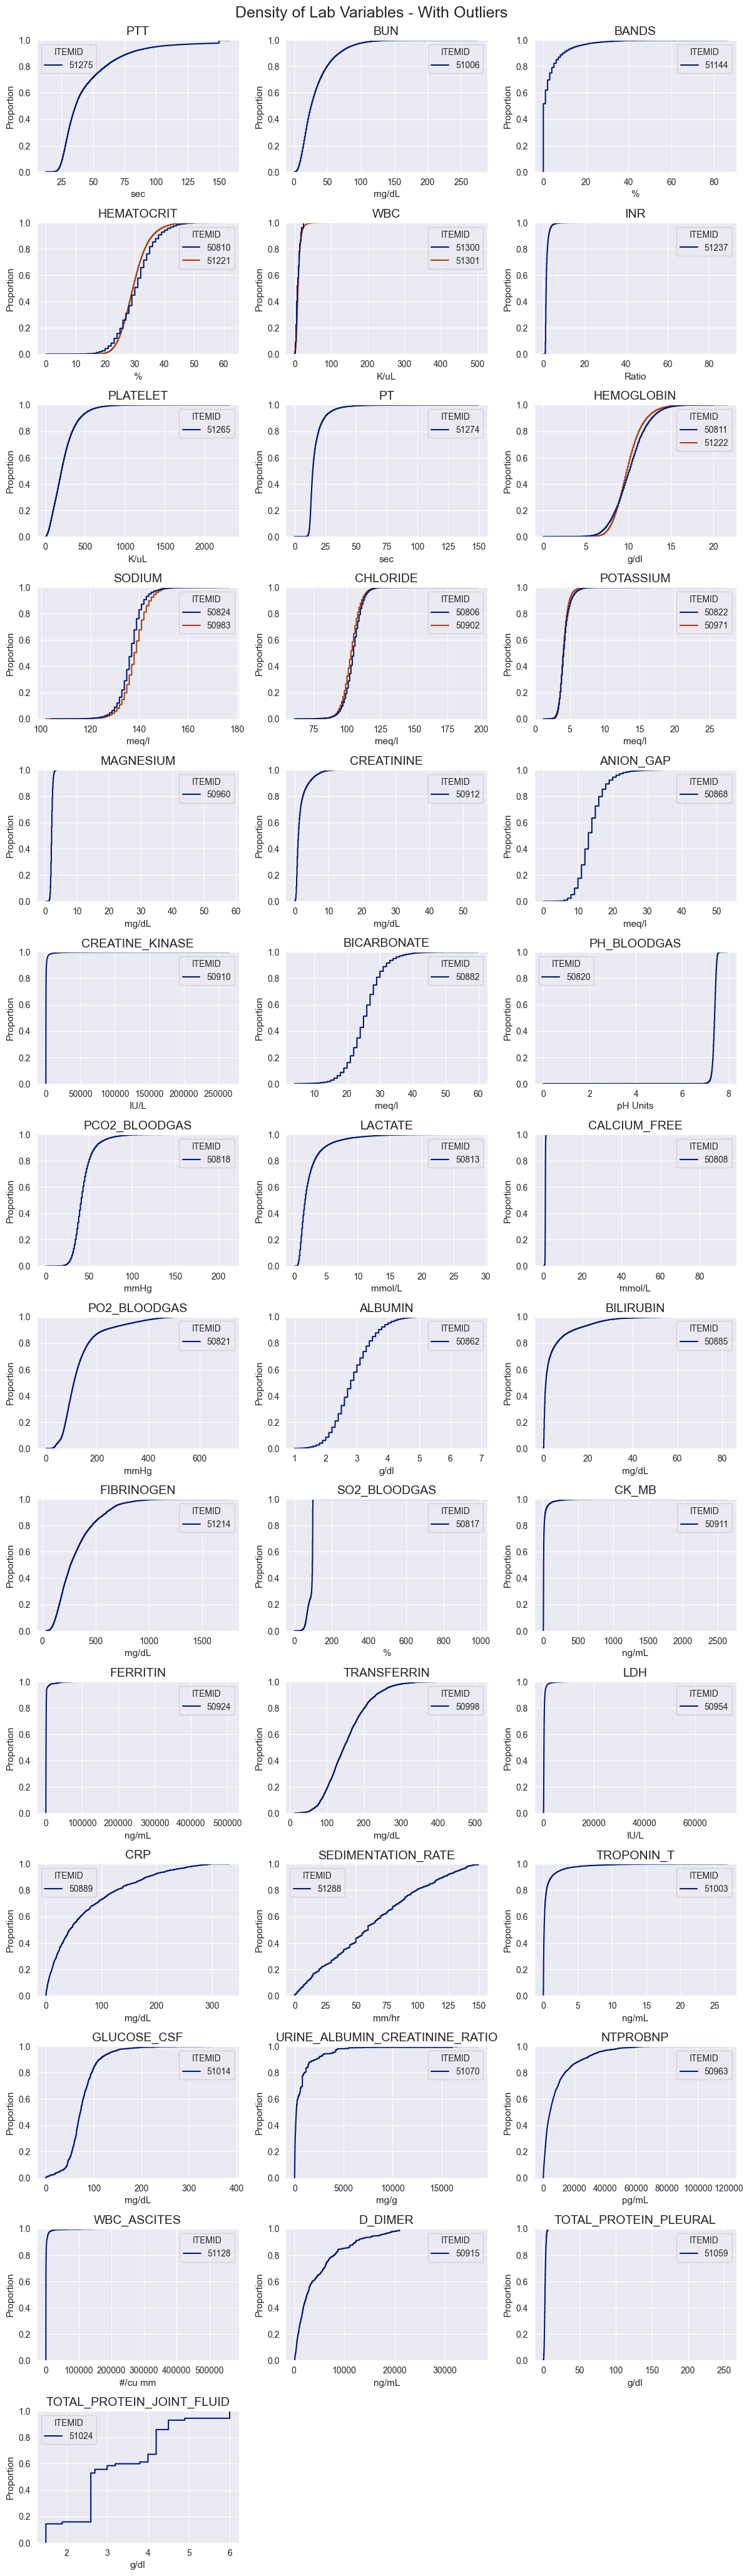

In [18]:
n_cols      = 3
n_labels    = len(df_labevents["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Density of Lab Variables - With Outliers", fontsize=18)
for i, label in enumerate(df_labevents["LABEL"].unique()):
    data = df_labevents[df_labevents["LABEL"] == label].sample(n=100000, random_state=42, replace=True)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.ecdfplot(data, x="VALUENUM", hue="ITEMID", palette="dark")
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Proportion", fontsize=11)    
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.967) 
plt.show()

### Violin-Plots

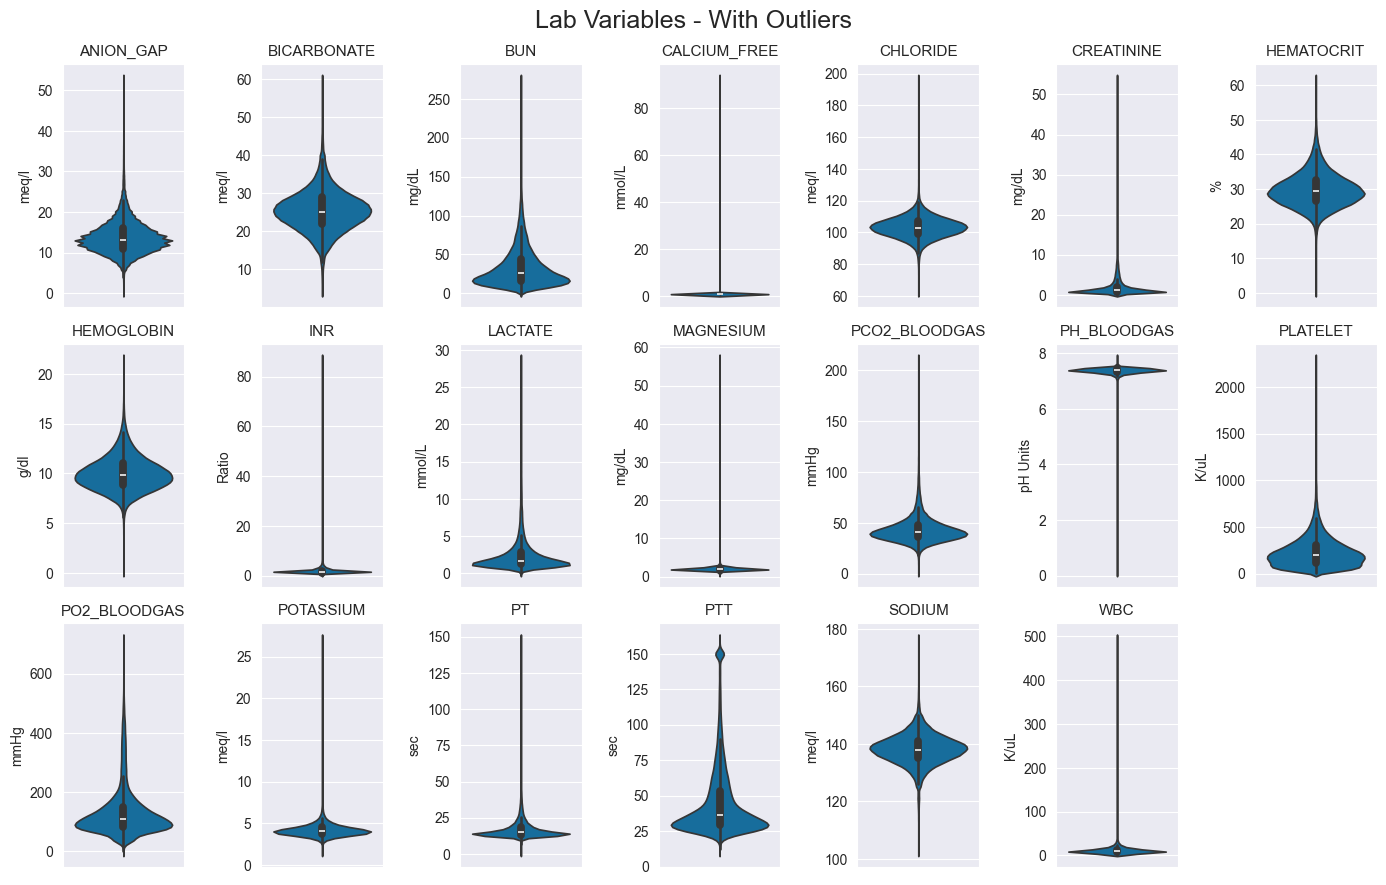

In [19]:
labels = pd.read_csv(project_path()+r"/data/target_data/df_labevents_time.csv", index_col=0).columns[4:]
n_labels = len(labels)

n_cols = 7
n_rows = int(np.ceil(n_labels / n_cols))  

plt.figure(figsize=(2 * n_cols, 3 * n_rows))
plt.suptitle("Lab Variables - With Outliers", fontsize=18)
for i, label in enumerate(labels):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=df_labevents[df_labevents['LABEL'] == label].sample(n=100000, random_state=42, replace=True), 
                   y="VALUENUM")
    plt.ylabel(map_units[label]) 
    plt.title(label, fontsize=11)

plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.92)
plt.show()

### Descriptive statistics

In [20]:
df_lab_group    = df_labevents[df_labevents["LABEL"].isin(labels)].groupby("LABEL")['LABEL'].count()
desc_lab = df_labevents.groupby("LABEL")[df_labevents.columns[4:]].describe().round(2).loc[labels].sort_values(by=("VALUENUM", "count"), ascending=False)
desc_lab[('VALUENUM', 'count')] = desc_lab[('VALUENUM', 'count')].astype(int)
desc_lab = desc_lab.sort_values(by=('VALUENUM', 'count'), ascending=False)
desc_lab

VALUENUM                                                        
                 count    mean     std    min     25%     50%     75%      max
POTASSIUM      2511721    4.16    0.77   0.60    3.70    4.10    4.50   538.00
HEMATOCRIT     2323127   29.85    4.96   0.00   26.50   29.40   32.60   390.00
SODIUM         2154067  138.26    5.58   1.07  135.00  138.00  141.00  1332.00
CHLORIDE       2080143  103.35    6.49   1.60   99.00  103.00  107.00   198.00
HEMOGLOBIN     1980360   10.00    1.73   0.00    8.80    9.80   11.00   130.00
CREATININE     1958150    1.84    2.00   0.00    0.70    1.10    2.00   808.00
BUN            1953918   33.33   24.57   0.00   16.00   26.00   44.00   290.00
BICARBONATE    1932137   25.45    5.37   2.00   22.00   25.00   29.00    65.00
ANION_GAP      1909638   13.85    4.00 -21.00   11.00   13.00   16.00    77.00
PLATELET       1862532  231.07  158.54   4.00  116.00  202.00  306.00  2813.00
MAGNESIUM      1798227    2.03    0.40   0.00    1.80    2.00    2.20    58.00
WBC            1794136   10.75    8.47   0.00    6.50    9.40   13.20   846.70
PH_BLOODGAS    1355289    7.38    0.09   0.00    7.33    7.39    7.44     7.99
PTT            1282829   45.75   26.03   0.00   29.20   36.00   53.30   193.30
PO2_BLOODGAS   1250663  132.26   83.36   0.00   82.00  109.00  151.00  1914.00
PCO2_BLOODGAS  1250642   43.27   12.32   0.00   36.00   41.00   48.00   247.00
INR            1212338    1.67    1.24   0.00    1.20    1.40    1.80   112.30
PT             1212080   17.20    9.60   0.00   13.30   14.80   18.30  1907.00
CALCIUM_FREE    639719    1.13    0.36   0.09    1.07    1.13    1.19   108.00
LACTATE         507213    2.48    2.35   0.00    1.20    1.70    2.80    36.00

## Percentage of outliers

In [21]:
labels

Index(['ANION_GAP', 'BICARBONATE', 'BUN', 'CALCIUM_FREE', 'CHLORIDE',
       'CREATININE', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE', 'MAGNESIUM',
       'PCO2_BLOODGAS', 'PH_BLOODGAS', 'PLATELET', 'PO2_BLOODGAS', 'POTASSIUM',
       'PT', 'PTT', 'SODIUM', 'WBC'],
      dtype='object')

In [22]:
labels = pd.read_csv(project_path()+r"/data/target_data/df_labevents_time.csv", index_col=0).columns[4:]
df_labevents_or                 = df_labevents.groupby("LABEL").apply(lambda group: remove_outliers_iqr(group)).reset_index(drop=True)
labeventsoutliers_percentage    = (1 - (df_labevents_or.groupby("LABEL")["VALUENUM"].count() / df_labevents.groupby("LABEL")["VALUENUM"].count()))
labeventsoutliers_percentage    = labeventsoutliers_percentage[labeventsoutliers_percentage.index.isin(labels)]
print("chart data percentage of outliers")
print(labeventsoutliers_percentage[labels].sort_values().apply(lambda x: str(round(x *100,2)) + "%"))

chart data percentage of outliers
CHLORIDE          1.69%
BICARBONATE       1.86%
PH_BLOODGAS       1.99%
HEMOGLOBIN        2.06%
MAGNESIUM         2.17%
ANION_GAP         2.19%
SODIUM            2.29%
HEMATOCRIT        2.35%
PLATELET          3.15%
POTASSIUM         3.25%
WBC               4.28%
BUN               4.47%
CALCIUM_FREE       4.8%
PCO2_BLOODGAS     4.81%
PTT                6.6%
PT                8.03%
INR               8.41%
PO2_BLOODGAS      8.47%
LACTATE           8.71%
CREATININE       11.26%
Name: VALUENUM, dtype: object


In [23]:
t = pd.DataFrame(labeventsoutliers_percentage)
t = t.sort_values(by="VALUENUM")
t["VALUENUM"] = t["VALUENUM"].apply(lambda x: str(round(x *100,2)) + "%")
t

VALUENUM
LABEL                 
CHLORIDE         1.69%
BICARBONATE      1.86%
PH_BLOODGAS      1.99%
HEMOGLOBIN       2.06%
MAGNESIUM        2.17%
ANION_GAP        2.19%
SODIUM           2.29%
HEMATOCRIT       2.35%
PLATELET         3.15%
POTASSIUM        3.25%
WBC              4.28%
BUN              4.47%
CALCIUM_FREE      4.8%
PCO2_BLOODGAS    4.81%
PTT               6.6%
PT               8.03%
INR              8.41%
PO2_BLOODGAS     8.47%
LACTATE          8.71%
CREATININE      11.26%

## Exploration Without Outliers

### Hist Plot

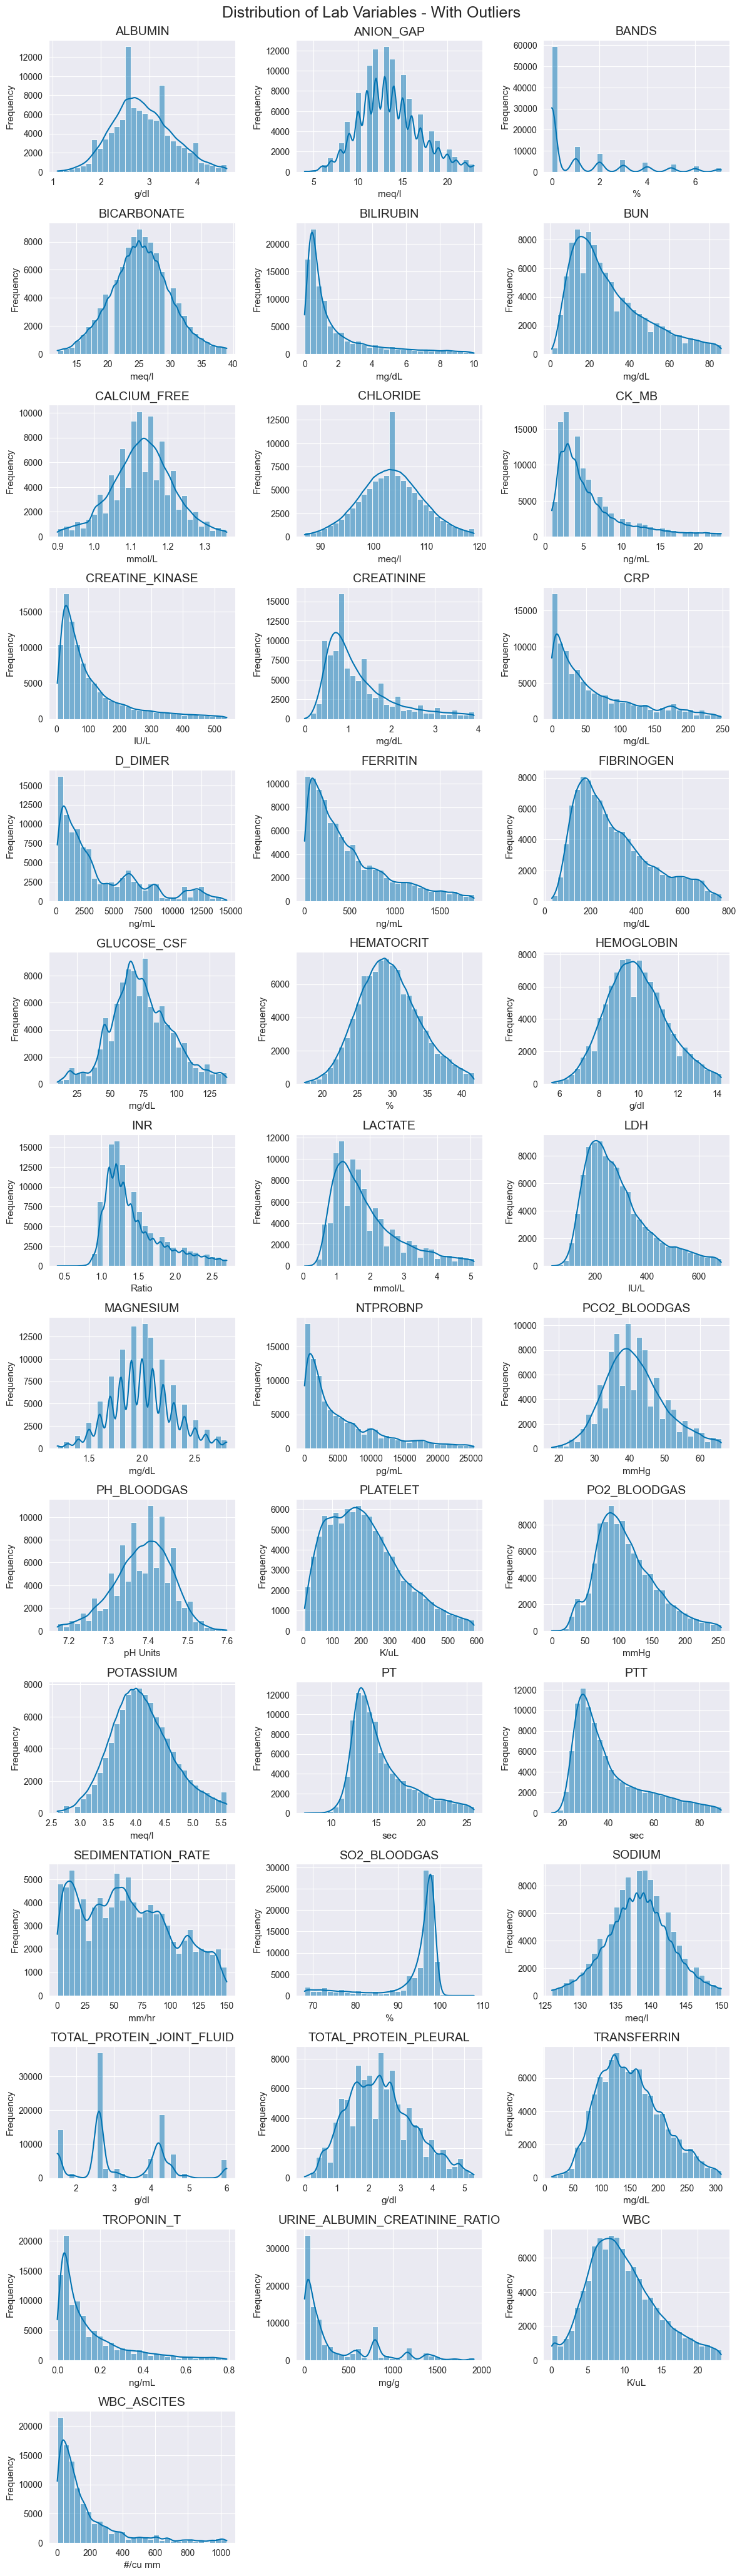

In [24]:
n_cols      = 3
n_labels    = len(df_labevents_or["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Distribution of Lab Variables - With Outliers", fontsize=18)
for i, label in enumerate(df_labevents_or["LABEL"].unique()):
    data = df_labevents_or[df_labevents_or["LABEL"] == label].sample(n=100000, random_state=42, replace=True)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data, x="VALUENUM", kde=True, bins=30)
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)    
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.967) 
plt.show()

### CDF plot

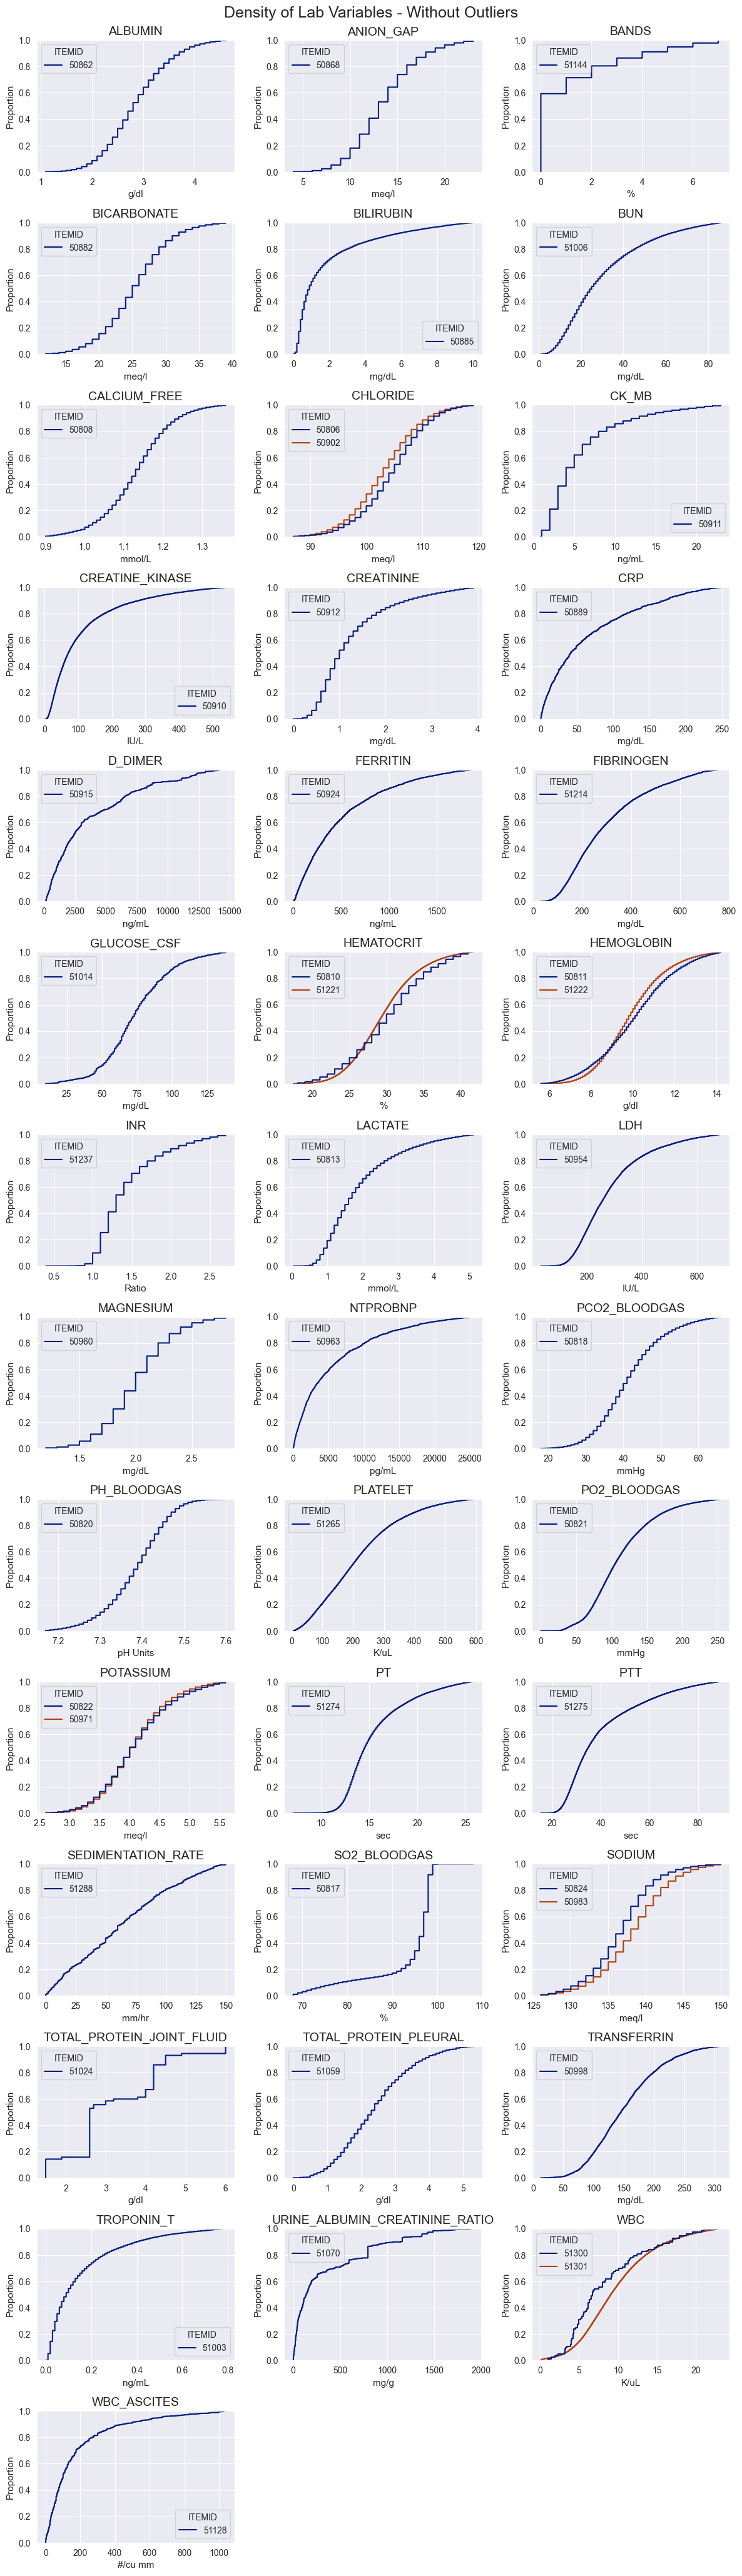

In [25]:
n_cols      = 3
n_labels    = len(df_labevents_or["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Density of Lab Variables - Without Outliers", fontsize=18)
for i, label in enumerate(df_labevents_or["LABEL"].unique()):
    data = df_labevents_or[df_labevents_or["LABEL"] == label].sample(n=100000, random_state=42, replace=True)
    plt.subplot(n_rows, n_cols, i + 1)
    sns.ecdfplot(data, x="VALUENUM", hue="ITEMID", palette="dark")
    plt.title(label, fontsize=14)
    plt.xlabel(map_units[label], fontsize=11) 
    plt.ylabel("Proportion", fontsize=11)    
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.967) 
plt.show()

### Violin-Plots

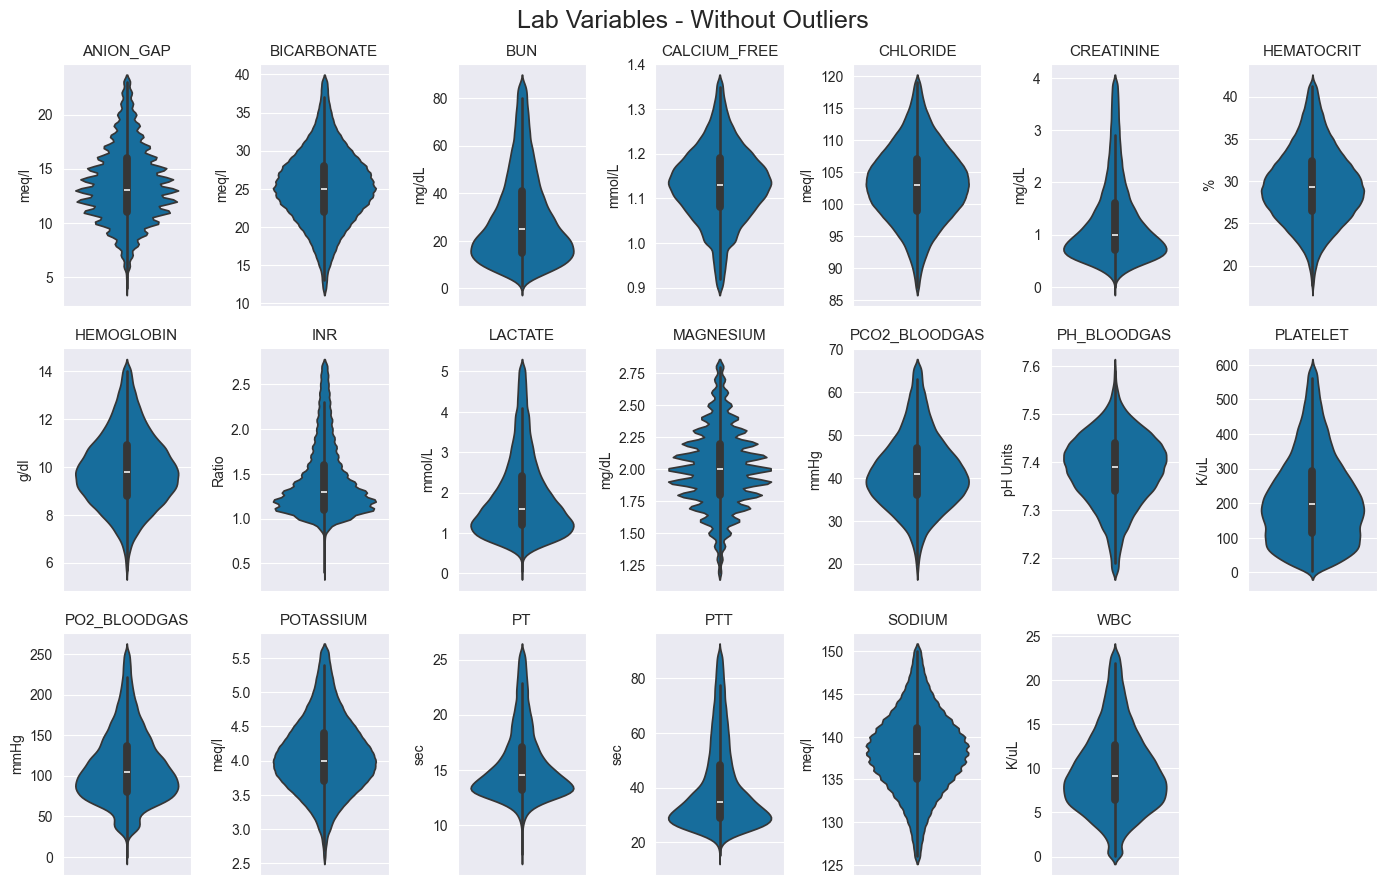

In [26]:
labels = pd.read_csv(project_path()+r"/data/target_data/df_labevents_time.csv", index_col=0).columns[4:]
n_labels = len(labels)

n_cols = 7
n_rows = int(np.ceil(n_labels / n_cols))  

plt.figure(figsize=(2 * n_cols, 3 * n_rows))
plt.suptitle("Lab Variables - Without Outliers", fontsize=18)
for i, label in enumerate(labels):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=df_labevents_or[df_labevents_or['LABEL'] == label].sample(n=100000, random_state=42, replace=True), 
                   y="VALUENUM")
    plt.ylabel(map_units[label]) 
    plt.title(label, fontsize=11)

plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.92)
plt.show()

### Descriptive statistics

In [27]:
df_labevents_or.groupby("LABEL")[df_labevents_or.columns[4:]].describe().round(2).sort_values(by=("VALUENUM", "count"), ascending=False)

VALUENUM                                     \
                                    count     mean      std     min      25%   
LABEL                                                                          
POTASSIUM                       2430122.0     4.09     0.55    2.54     3.70   
HEMATOCRIT                      2268535.0    29.58     4.41   17.40    26.50   
SODIUM                          2104702.0   138.28     4.59  126.00   135.00   
CHLORIDE                        2044919.0   103.32     5.94   87.00    99.00   
HEMOGLOBIN                      1939652.0     9.92     1.56    5.60     8.80   
BICARBONATE                     1896112.0    25.33     4.88   12.00    22.00   
ANION_GAP                       1867753.0    13.56     3.39    4.00    11.00   
BUN                             1866600.0    29.92    18.87    0.00    15.00   
PLATELET                        1803782.0   214.55   128.21    4.00   113.00   
MAGNESIUM                       1759157.0     2.01     0.30    1.20     1.80   
CREATININE                      1737627.0     1.26     0.80    0.00     0.70   
WBC                             1717365.0     9.74     4.70    0.00     6.40   
PH_BLOODGAS                     1328288.0     7.39     0.07    7.17     7.34   
PTT                             1198161.0    40.35    15.66    0.00    28.80   
PCO2_BLOODGAS                   1190441.0    41.49     8.64   18.00    36.00   
PO2_BLOODGAS                    1144747.0   111.46    44.70    0.00    80.00   
PT                              1114787.0    15.54     3.25    7.00    13.20   
INR                             1110321.0     1.45     0.41    0.40     1.10   
CALCIUM_FREE                     609001.0     1.13     0.09    0.90     1.08   
BILIRUBIN                        483234.0     1.85     2.19    0.00     0.40   
LACTATE                          463022.0     1.90     1.01    0.00     1.20   
SO2_BLOODGAS                     385865.0    93.51     7.87   68.00    94.00   
ALBUMIN                          363178.0     2.86     0.62    1.10     2.40   
LDH                              260587.0   285.87   124.03   21.00   194.00   
CREATINE_KINASE                  244710.0   113.10   112.69    3.00    35.00   
CK_MB                            148312.0     5.91     4.63    0.90     3.00   
TROPONIN_T                       141341.0     0.16     0.17    0.00     0.04   
BANDS                            138693.0     1.18     1.85    0.00     0.00   
FIBRINOGEN                       138199.0   299.47   163.18   31.00   172.00   
TRANSFERRIN                       36964.0   151.04    55.55   13.00   109.00   
FERRITIN                          31334.0   487.46   434.99    1.40   149.25   
NTPROBNP                          14379.0  5717.41  5859.77    7.00  1292.00   
SEDIMENTATION_RATE                11614.0    62.11    40.10    0.00    29.00   
WBC_ASCITES                       11099.0   174.82   207.62    0.00    41.00   
CRP                               10695.0    64.23    62.48    0.06    13.80   
TOTAL_PROTEIN_PLEURAL              7087.0     2.39     1.04    0.00     1.60   
GLUCOSE_CSF                        6497.0    73.59    23.20   10.00    59.00   
D_DIMER                            2355.0  3803.71  3571.20  151.00  1020.00   
URINE_ALBUMIN_CREATININE_RATIO     1311.0   356.11   439.29    2.00    42.15   
TOTAL_PROTEIN_JOINT_FLUID            70.0     3.21     1.20    1.50     2.60   

                                                            
                                    50%      75%       max  
LABEL                                                       
POTASSIUM                          4.00     4.40      5.64  
HEMATOCRIT                        29.30    32.40     41.70  
SODIUM                           138.00   141.00    150.00  
CHLORIDE                         103.00   107.00    119.00  
HEMOGLOBIN                         9.80    10.90     14.20  
BICARBONATE                       25.00    28.00     39.00  
ANION_GAP                         13.00    

# Output

## Read data

In [28]:
df_output   = pd.read_csv(project_path()+r"/data/extracted_data/output.csv", index_col=0).merge(df_filter[["ICUSTAY_ID"]])
d_items     = pd.read_csv(project_path()+r"/data/extracted_data/d_items.csv", index_col=0)
df_output   = df_output.drop(columns="LABEL").merge(d_items[["LABEL", "ITEMID"]], on="ITEMID")

## Exploration With Outliers

### Hist Plot

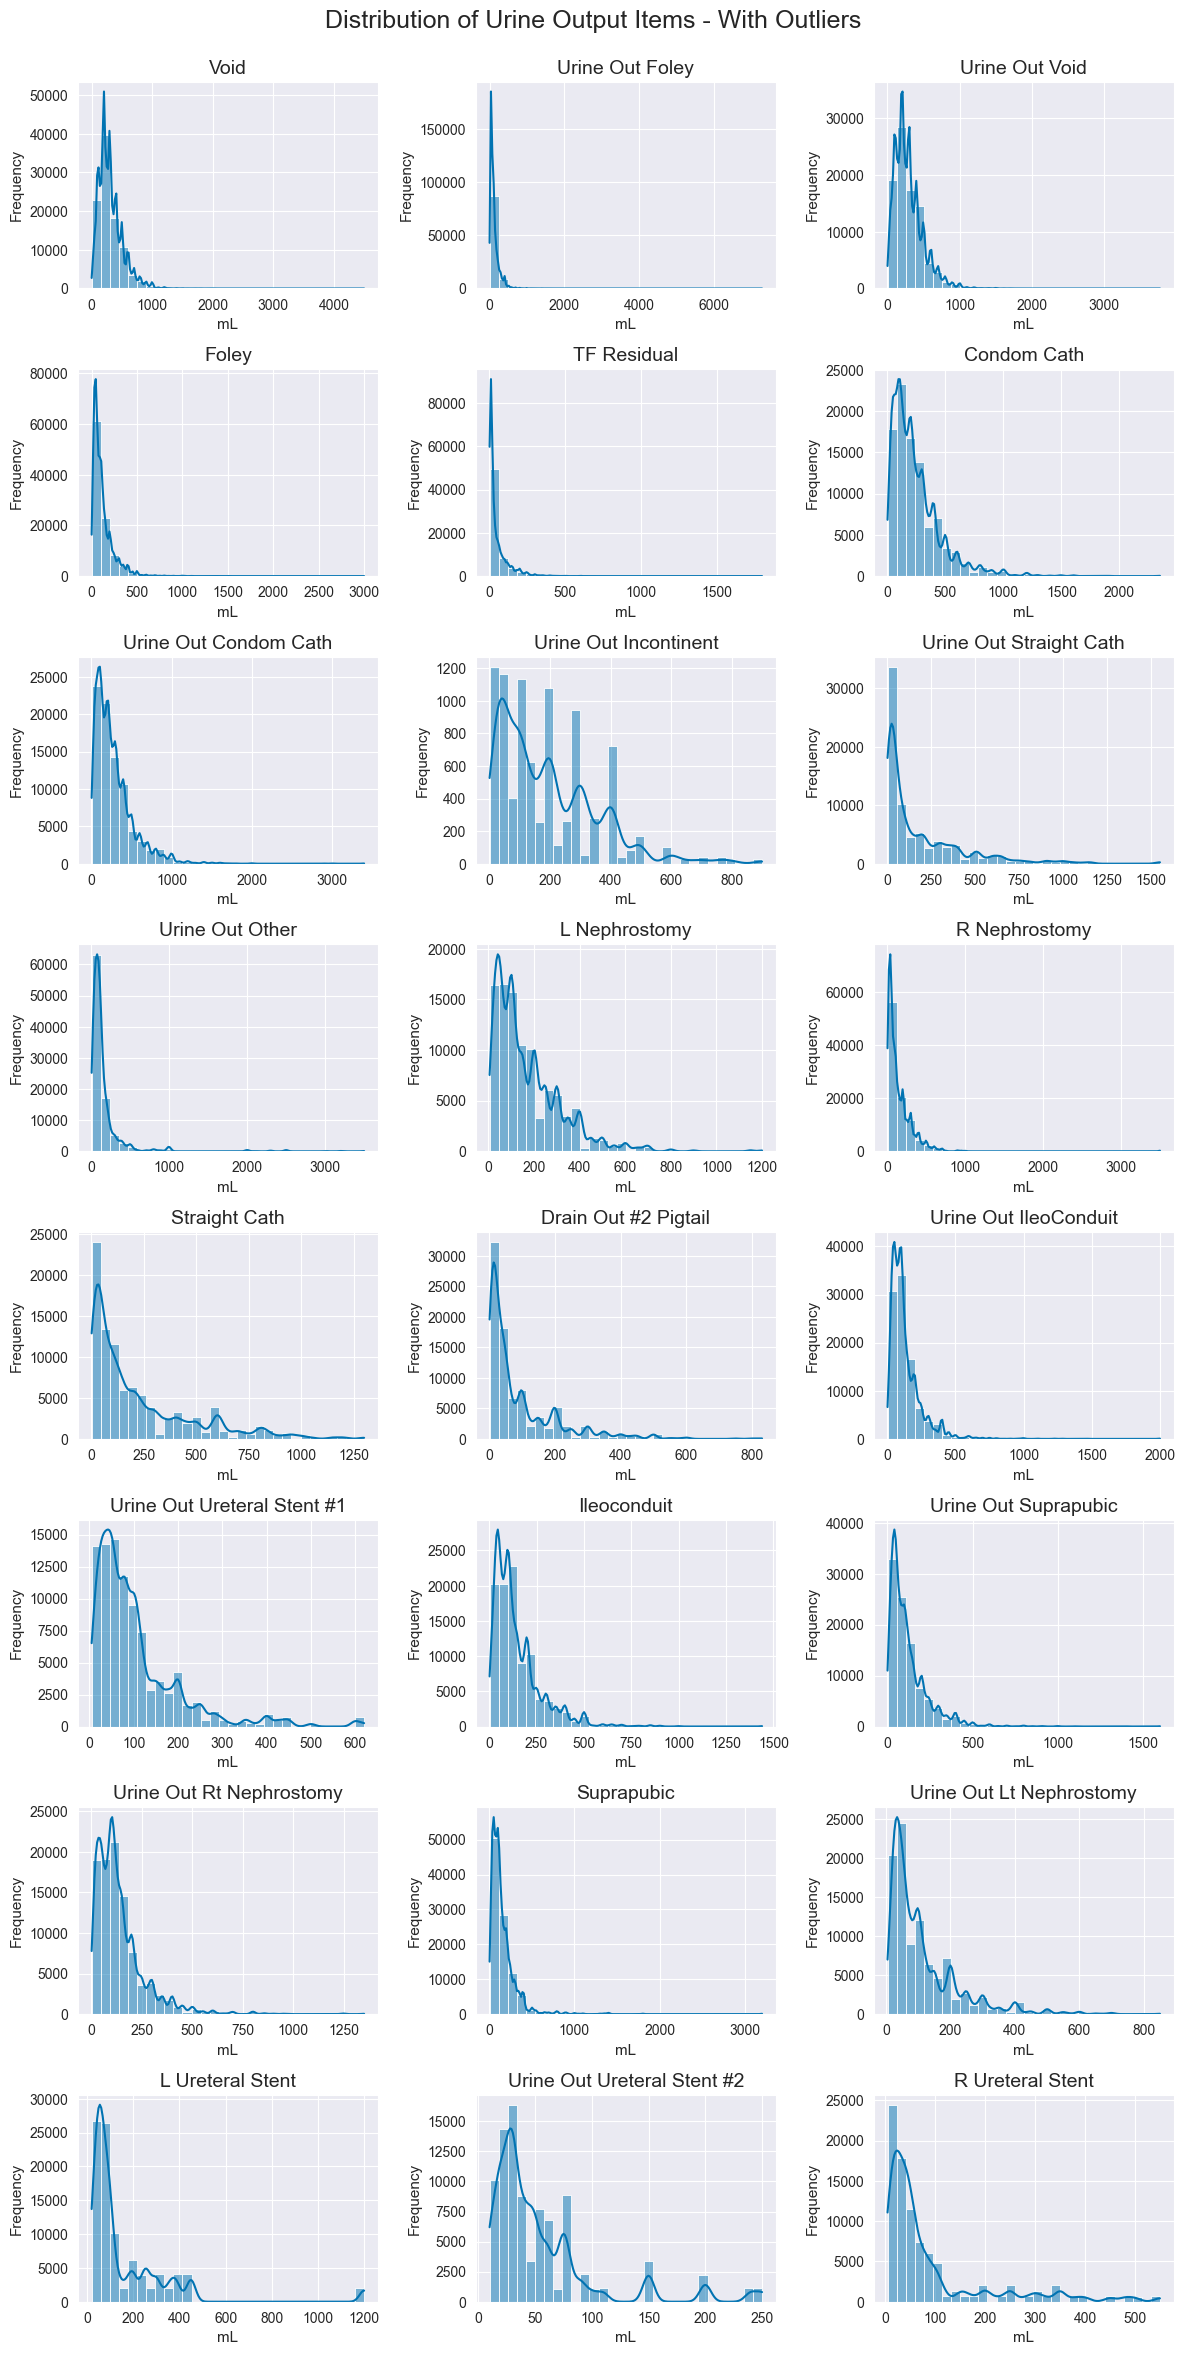

In [29]:
n_cols      = 3
n_labels    = len(df_output["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Distribution of Urine Output Items - With Outliers", fontsize=18)
for i, label in enumerate(df_output["LABEL"].unique()):
    data = df_output[df_output["LABEL"] == label].sample(n=100000, random_state=42, replace=True).reset_index()
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data, x="VALUENUM", kde=True, bins=30)
    plt.title(label, fontsize=14)
    plt.xlabel("mL", fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)    
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.95) 
plt.show()

### CDF plot

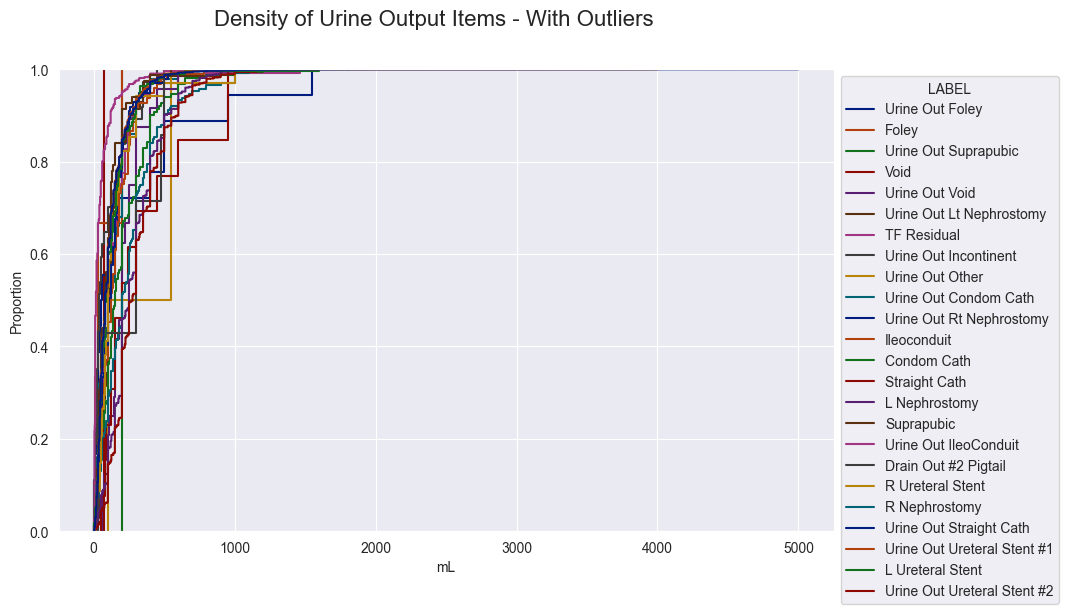

In [30]:
plt.figure(figsize=(10,6))
plt.suptitle("Density of Urine Output Items - With Outliers", fontsize=16)
data = df_output.sample(n=100000, random_state=42, replace=True).reset_index()
ax = sns.ecdfplot(data, x="VALUENUM", hue="LABEL", palette="dark")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("mL")
plt.show()

### Violin-Plots

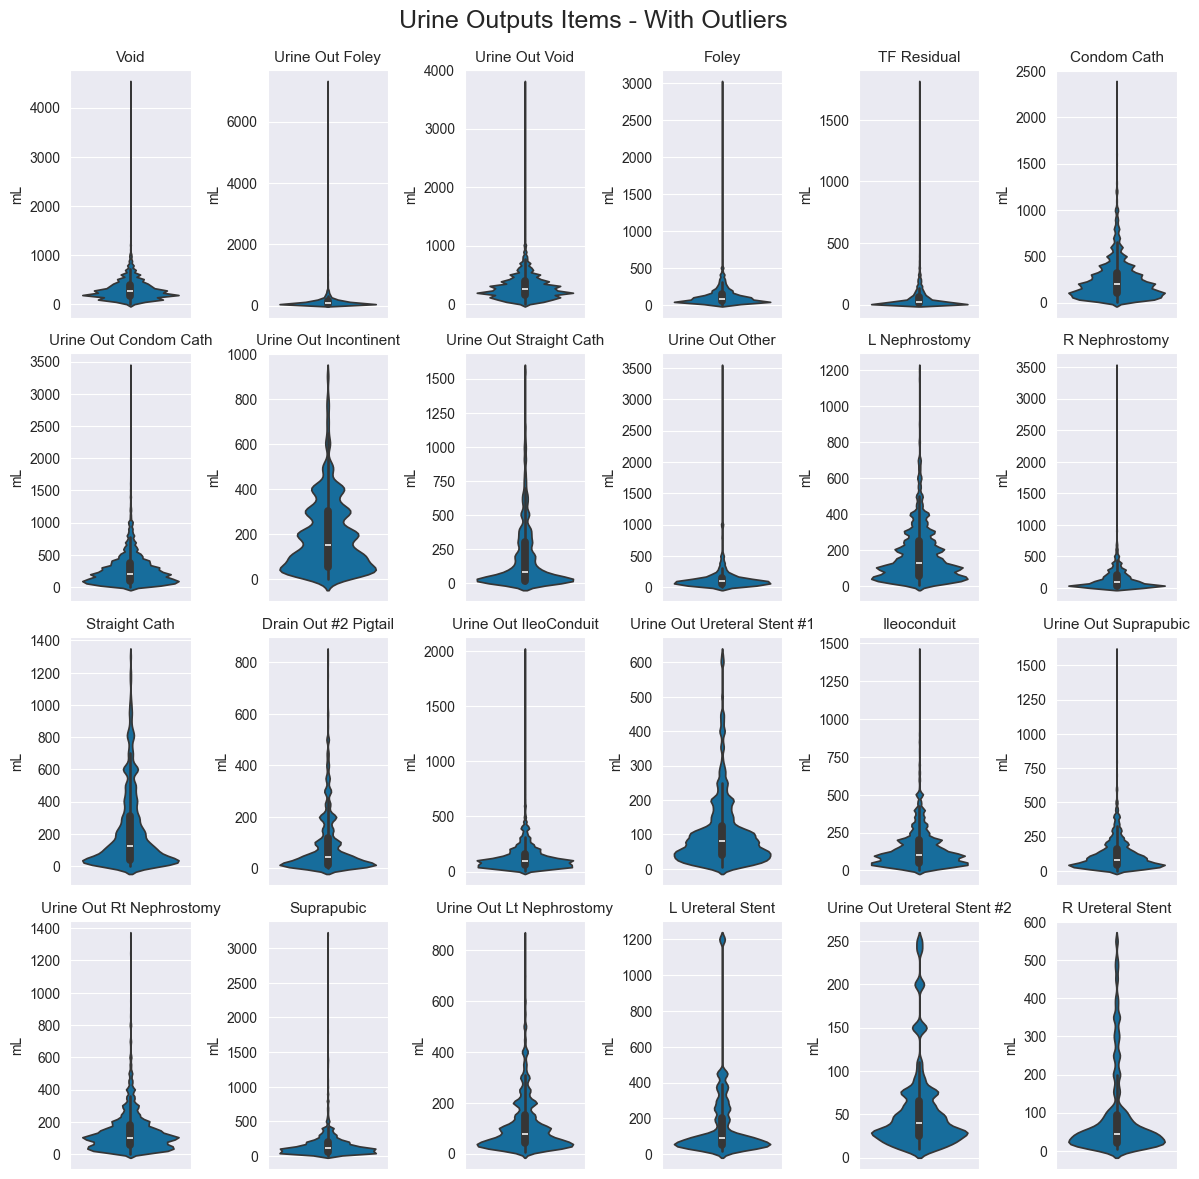

In [31]:
labels = df_output["LABEL"].unique()
n_labels = len(labels)

n_cols = 6
n_rows = int(np.ceil(n_labels / n_cols))  

plt.figure(figsize=(2 * n_cols, 3 * n_rows))
plt.suptitle("Urine Outputs Items - With Outliers", fontsize=18)
for i, label in enumerate(labels):
    data = df_output[df_output["LABEL"] == label].sample(n=100000, random_state=42, replace=True).reset_index()
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=data, 
                   y="VALUENUM")
    plt.ylabel("mL") 
    plt.title(label, fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.93)
plt.show()

### Descriptive statistics

In [32]:
df_output.groupby("LABEL")[df_output.columns[3:]].describe().round(2).sort_values(by=("VALUENUM", "count"), ascending=False)
desc_output = df_output.groupby("LABEL")[df_output.columns[3:]].describe().round(2).sort_values(by=("VALUENUM", "count"), ascending=False)
desc_output[('VALUENUM', 'count')] = desc_output[('VALUENUM', 'count')].astype(int)
desc_output = desc_output.sort_values(by=('VALUENUM', 'count'), ascending=False)
desc_output

VALUENUM                                      \
                               count    mean     std   min    25%    50%   
LABEL                                                                      
Urine Out Foley              1875142  120.43  131.19   0.2   43.0   80.0   
Foley                        1170909  118.30  127.96   1.0   45.0   80.0   
Void                           61930  308.39  198.75   0.3  180.0  275.0   
Urine Out Void                 61530  291.63  199.05   1.0  150.0  250.0   
TF Residual                    16829   49.56   70.83   1.0   10.0   20.0   
Urine Out Condom Cath           8315  273.54  244.23   2.0  100.0  200.0   
Urine Out Suprapubic            6705  120.37  116.55   1.0   45.0   80.0   
Condom Cath                     5546  243.91  213.27   1.0  100.0  200.0   
Urine Out IleoConduit           4655  130.70  118.84   2.0   60.0  100.0   
Urine Out Rt Nephrostomy        2684  137.63  120.92   2.0   55.0  100.0   
Urine Out Lt Nephrostomy        2655  109.79  106.42   5.0   40.0   75.0   
Ileoconduit                     2618  142.28  125.23   2.0   50.0  100.0   
Suprapubic                      2482  153.44  160.18   5.0   60.0  110.0   
Urine Out Other                 1673  151.72  258.88   5.0   50.0  100.0   
R Nephrostomy                   1410  143.74  169.51   2.0   40.0  100.0   
Drain Out #2 Pigtail            1226   90.69  113.17   2.0   15.0   45.0   
L Nephrostomy                   1149  169.71  147.96   5.0   55.0  125.0   
Urine Out Straight Cath          551  189.31  243.83   0.5   21.5   80.0   
Straight Cath                    436  223.55  248.49   1.0   40.0  122.5   
Urine Out Ureteral Stent #1      397  103.61   99.08   5.0   40.0   80.0   
Urine Out Incontinent            252  191.83  161.51   1.0   50.0  150.0   
R Ureteral Stent                 131   89.81  114.30   5.0   20.0   45.0   
Urine Out Ureteral Stent #2       81   54.46   49.51  10.0   25.0   40.0   
L Ureteral Stent                  46  158.80  197.64  20.0   50.0   90.0   

                                             
                               75%      max  
LABEL                                        
Urine Out Foley              150.0  11000.0  
Foley                        150.0  47050.0  
Void                         400.0   4500.0  
Urine Out Void               400.0   3775.0  
TF Residual                   60.0   1800.0  
Urine Out Condom Cath        375.0   3400.0  
Urine Out Suprapubic         160.0   1600.0  
Condom Cath                  320.0   2350.0  
Urine Out IleoConduit        160.0   2000.0  
Urine Out Rt Nephrostomy     180.0   1350.0  
Urine Out Lt Nephrostomy     150.0    850.0  
Ileoconduit                  200.0   1440.0  
Suprapubic                   200.0   3200.0  
Urine Out Other              150.0   3500.0  
R Nephrostomy                200.0   3500.0  
Drain Out #2 Pigtail         120.0    830.0  
L Nephrostomy                250.0   1200.0  
Urine Out Straight Cath      300.0   1550.0  
Straight Cath                310.0   1300.0  
Urine Out Ureteral Stent #1  125.0    620.0  
Urine Out Incontinent        300.0    900.0  
R Ureteral Stent              92.5    550.0  
Urine Out Ureteral Stent #2   65.0    250.0  
L Ureteral Stent             200.0   1200.0

## Percentage of outliers

In [33]:
df_output_or                 = df_output.groupby("LABEL").apply(lambda group: remove_outliers_iqr(group)).reset_index(drop=True)
output_outliers_percentage   = (1 - (df_output_or.groupby("LABEL")["VALUENUM"].count() / df_output.groupby("LABEL")["VALUENUM"].count()))
print("chart data percentage of outliers")
print(output_outliers_percentage.sort_values().apply(lambda x: str(round(x *100,2)) + "%"))

chart data percentage of outliers
LABEL
Urine Out Incontinent           1.59%
Urine Out Void                  2.71%
L Nephrostomy                   2.87%
Ileoconduit                     3.25%
Suprapubic                      3.46%
Void                            3.77%
Urine Out Straight Cath         4.36%
Urine Out Condom Cath           4.55%
Condom Cath                     4.99%
R Nephrostomy                   5.04%
Urine Out Rt Nephrostomy        5.07%
Urine Out Lt Nephrostomy        5.08%
Urine Out Suprapubic            5.71%
Straight Cath                   5.96%
L Ureteral Stent                6.52%
Foley                           6.54%
Urine Out IleoConduit            6.6%
Urine Out Ureteral Stent #1      6.8%
Urine Out Foley                 6.83%
Drain Out #2 Pigtail            7.91%
Urine Out Other                 8.31%
Urine Out Ureteral Stent #2     8.64%
TF Residual                     9.94%
R Ureteral Stent               12.98%
Name: VALUENUM, dtype: object


In [34]:
t = pd.DataFrame(output_outliers_percentage)
t = t.sort_values(by="VALUENUM")
t["VALUENUM"] = t["VALUENUM"].apply(lambda x: str(round(x *100,2)) + "%")
t

VALUENUM
LABEL                               
Urine Out Incontinent          1.59%
Urine Out Void                 2.71%
L Nephrostomy                  2.87%
Ileoconduit                    3.25%
Suprapubic                     3.46%
Void                           3.77%
Urine Out Straight Cath        4.36%
Urine Out Condom Cath          4.55%
Condom Cath                    4.99%
R Nephrostomy                  5.04%
Urine Out Rt Nephrostomy       5.07%
Urine Out Lt Nephrostomy       5.08%
Urine Out Suprapubic           5.71%
Straight Cath                  5.96%
L Ureteral Stent               6.52%
Foley                          6.54%
Urine Out IleoConduit           6.6%
Urine Out Ureteral Stent #1     6.8%
Urine Out Foley                6.83%
Drain Out #2 Pigtail           7.91%
Urine Out Other                8.31%
Urine Out Ureteral Stent #2    8.64%
TF Residual                    9.94%
R Ureteral Stent              12.98%

## Exploration Without Outliers

### Hist Plot

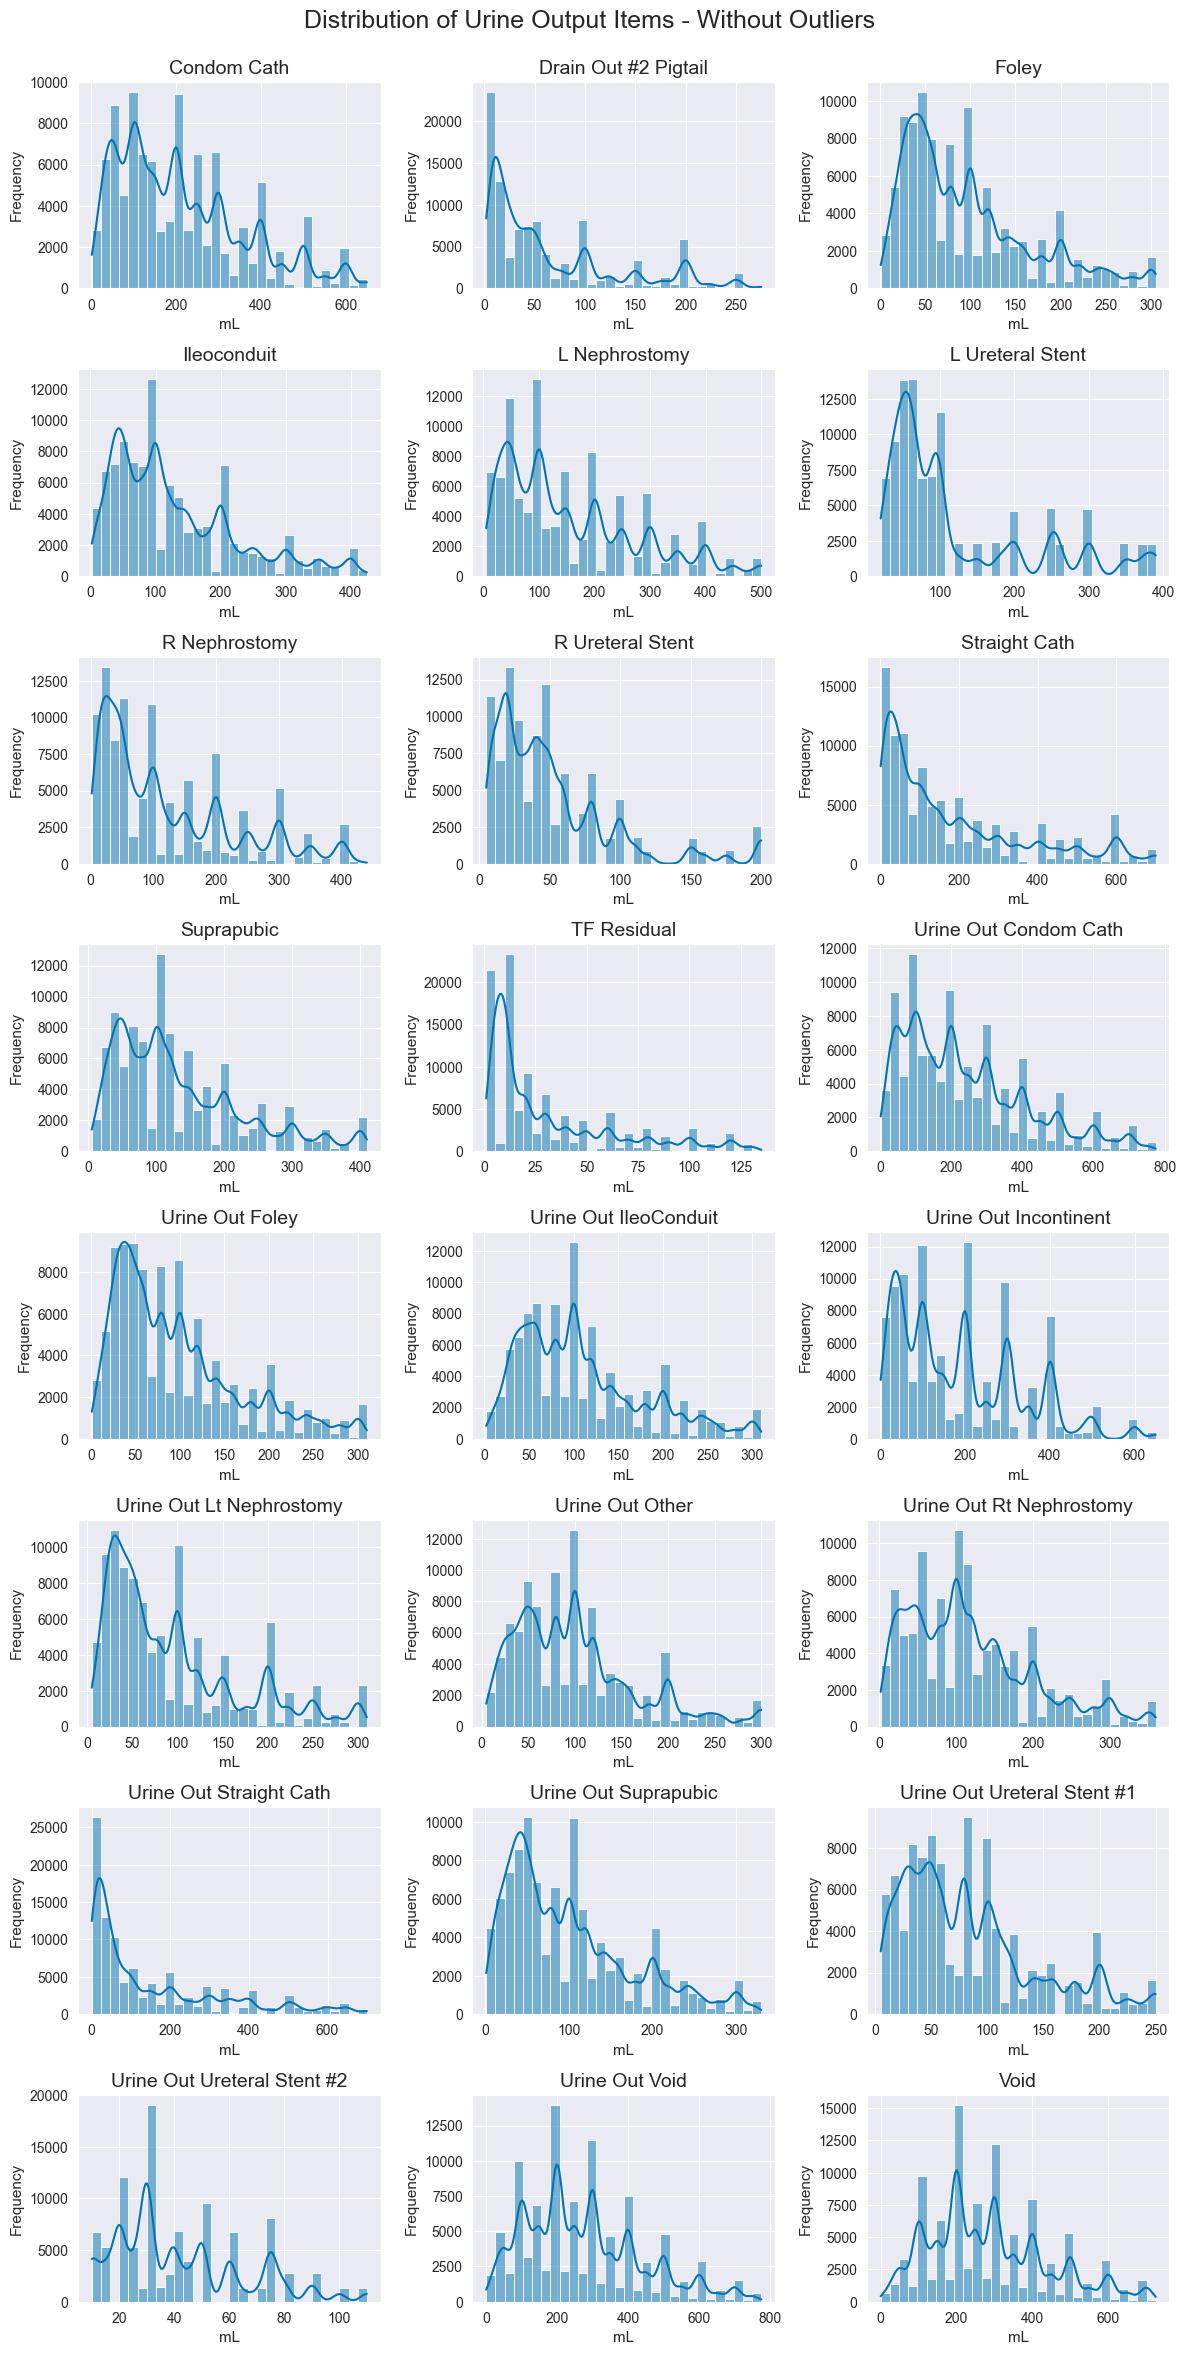

In [35]:
n_cols      = 3
n_labels    = len(df_output_or["LABEL"].unique())
n_rows      = int(np.ceil(n_labels / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.suptitle("Distribution of Urine Output Items - Without Outliers ", fontsize=18)
for i, label in enumerate(df_output_or["LABEL"].unique()):
    data = df_output_or[df_output_or["LABEL"] == label].sample(n=100000, random_state=42, replace=True).reset_index()
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data, x="VALUENUM", kde=True, bins=30)
    plt.title(label, fontsize=14)
    plt.xlabel("mL", fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)    
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.95) 
plt.show()

### CDF plot

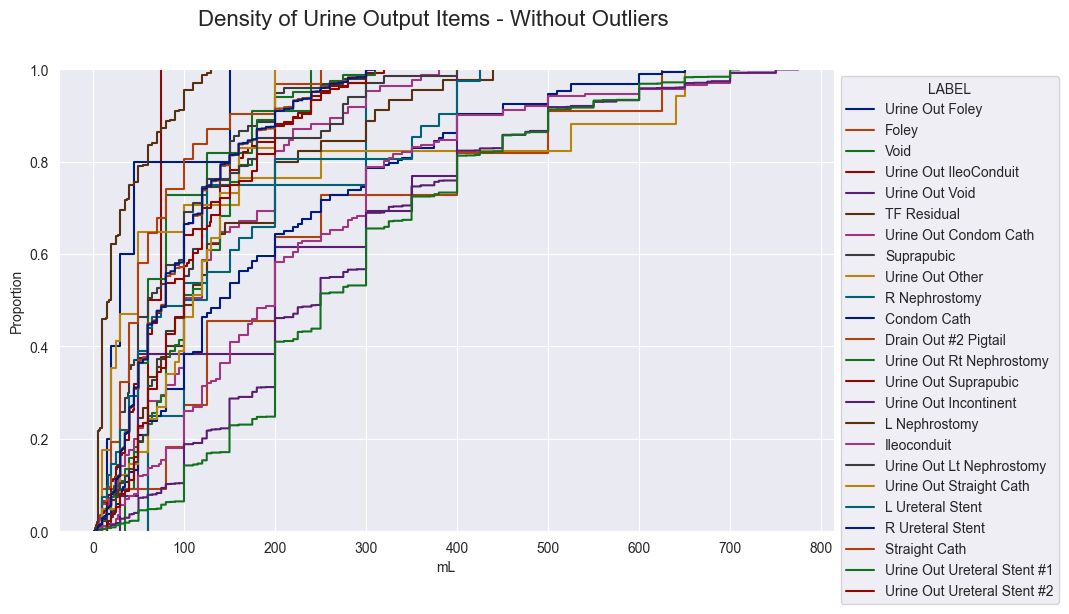

In [36]:
plt.figure(figsize=(10,6))
plt.suptitle("Density of Urine Output Items - Without Outliers", fontsize=16)
data = df_output_or.sample(n=100000, random_state=42, replace=True).reset_index()
ax = sns.ecdfplot(data, x="VALUENUM", hue="LABEL", palette="dark")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("mL")
plt.show()

### Violin-Plots

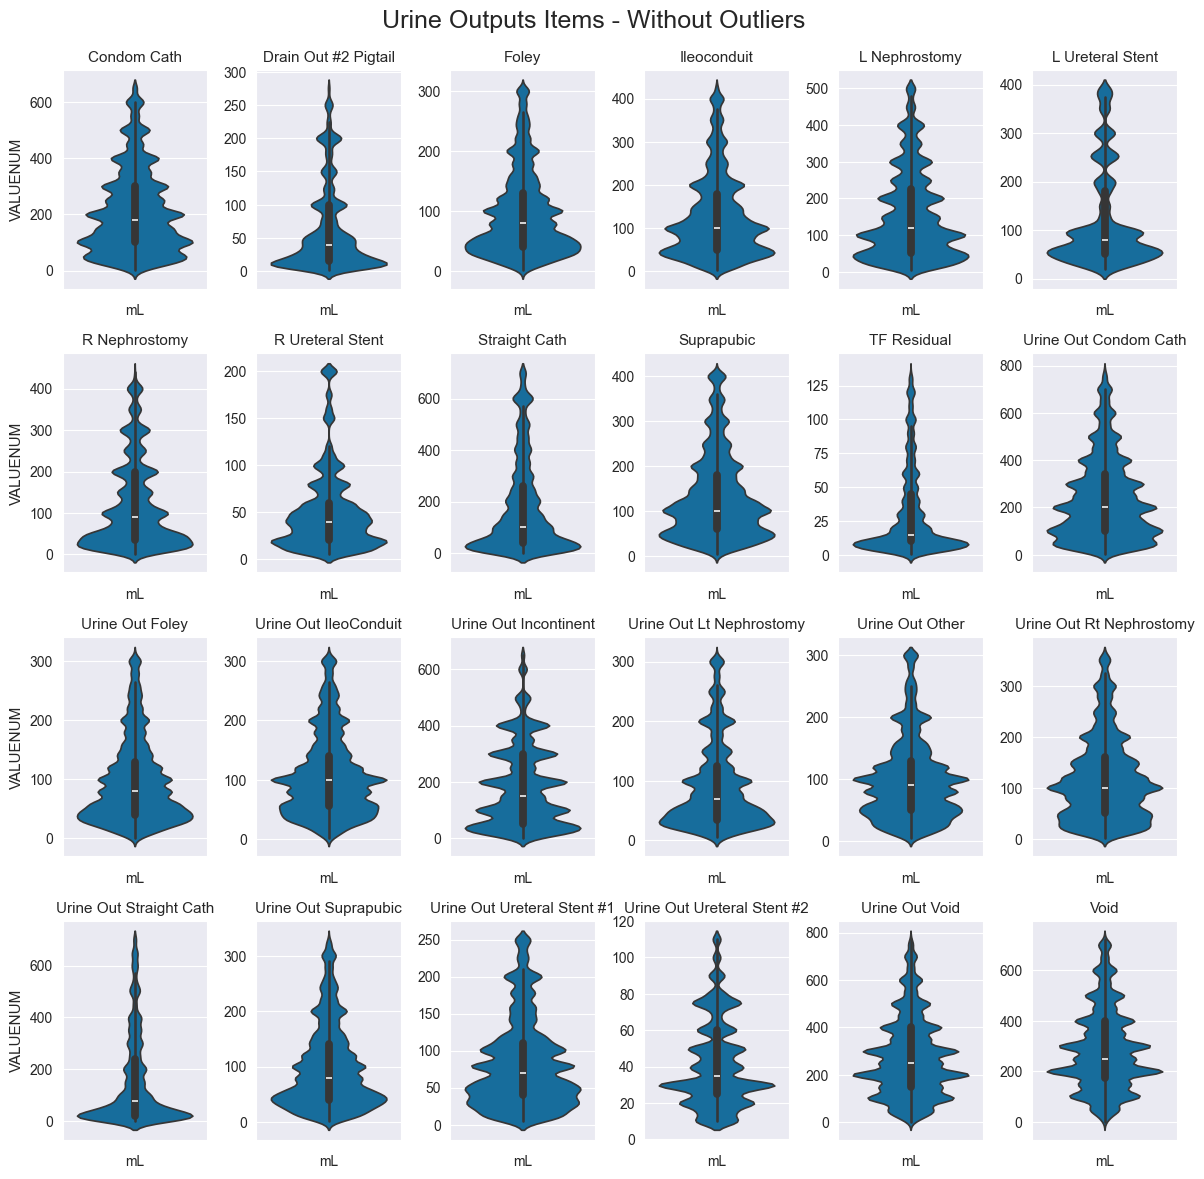

In [37]:
labels = df_output_or["LABEL"].unique()
n_labels = len(labels)

n_cols = 6
n_rows = int(np.ceil(n_labels / n_cols))  

plt.figure(figsize=(2 * n_cols, 3 * n_rows))
plt.suptitle("Urine Outputs Items - Without Outliers", fontsize=18)
for i, label in enumerate(labels):
    data = df_output_or[df_output_or["LABEL"] == label].sample(n=100000, random_state=42, replace=True).reset_index()
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=data, 
                   y="VALUENUM")
    if i % n_cols == 0:
        plt.ylabel("VALUENUM", fontsize=11)
    else:
        plt.ylabel("")
    plt.xlabel("mL") 
    plt.title(label, fontsize=11)
plt.tight_layout(pad=1.2)
plt.subplots_adjust(top=0.93)
plt.show()

### Descriptive statistics

In [38]:
df_output_or.groupby("ITEMID")[df_output.columns[3:]].describe().round(2).sort_values(by=("VALUENUM", "count"), ascending=False)

VALUENUM                                                  
            count    mean     std   min    25%    50%    75%    max
ITEMID                                                             
40055   1747141.0   95.22   69.83   0.2   40.0   80.0  130.0  310.0
226559  1094331.0   95.54   69.91   1.0   40.0   80.0  130.0  305.0
40069     59863.0  273.37  164.47   1.0  150.0  250.0  400.0  775.0
226560    59593.0  285.00  157.97   0.3  175.0  250.0  400.0  725.0
227510    15157.0   30.95   32.15   1.0   10.0   15.0   45.0  135.0
40094      7937.0  238.00  171.88   2.0  100.0  200.0  350.0  775.0
40715      6322.0  100.09   75.24   1.0   40.0   80.0  140.0  330.0
226561     5269.0  209.88  148.28   1.0  100.0  180.0  300.0  650.0
40473      4348.0  107.71   68.85   2.0   55.0  100.0  140.0  310.0
40057      2548.0  118.06   80.84   2.0   50.0  100.0  160.0  360.0
226584     2533.0  127.99   95.37   2.0   50.0  100.0  180.0  425.0
40056      2520.0   92.08   72.13   5.0   35.0   70.0  125.0  310.0
226563     2396.0  132.79   94.13   5.0   60.0  100.0  180.0  410.0
40405      1534.0   99.67   64.89   5.0   50.0   90.0  130.0  300.0
226564     1339.0  119.18  105.61   2.0   35.0   90.0  200.0  440.0
40086      1129.0   64.62   65.53   2.0   15.0   40.0  100.0  275.0
226565     1116.0  154.83  118.98   5.0   50.0  120.0  225.0  500.0
40428       527.0  153.51  175.03   0.5   20.0   75.0  245.0  700.0
226567      410.0  180.62  182.86   1.0   40.0  100.0  260.0  700.0
40096       370.0   83.08   59.58   5.0   40.0   70.0  110.0  250.0
40085       248.0  182.18  143.29   1.0   50.0  150.0  300.0  650.0
226557      114.0   50.70   42.66   5.0   20.0   40.0   60.0  200.0
40651        74.0   41.50   23.76  10.0   25.0   33.5   57.5  110.0
226558       43.0  121.05  102.68  20.0   50.0   80.0  165.0  390.0